In [1]:
import collections
import torchvision
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import random
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
from models import DQN_square, DQN_dueling, NoisyNet_Dueling, NoisyNet, Categorical_DQN
from helper_DQN import scale_and_resize

In [2]:
class ExperienceMemory:
    def __init__(self, replay_size=100000):
        self.replay_size = replay_size
        self.replay = []

    def add(self, experience: Experience):
        """
        pushes an experience to the Replay Memory by updating the interior representation.
        :param experience: list of old state, reward, action and new state to be added to memory
        """
        if len(self.replay) > self.replay_size:
            self.replay = self.replay[1:]
        self.replay.append(experience)

    def sample(self, batch_size: int):
        """
        sample batch_size number of experiences from the Replay Memory
        :param batch_size: size of sample
        :return:
        """
        return random.sample(self.replay, batch_size)

    def __len__(self):
        return len(self.replay)

NameError: name 'Experience' is not defined

In [ ]:
Experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])


class PrioritizedExperienceReplayBuffer:

    def __init__(self, batch_size: int, buffer_size: int, alpha: float = 0.0,
                 random_state: np.random.RandomState = None) -> None:

        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer_length = 0  # current number of prioritized experience tuples in buffer
        self._buffer = np.empty(self._buffer_size, dtype=[("priority", np.float32), ("experience", Experience)])
        self._alpha = alpha
        self._random_state = np.random.RandomState() if random_state is None else random_state

    def __len__(self) -> int:
        return self._buffer_length

    def add(self, experience: Experience) -> None:
        priority = 1.0 if self.is_empty() else self._buffer["priority"].max()
        if self.is_full():
            if priority > self._buffer["priority"].min():
                idx = self._buffer["priority"].argmin()
                self._buffer[idx] = (priority, experience)
            else:
                pass  # low priority experiences should not be included in buffer
        else:
            self._buffer[self._buffer_length] = (priority, experience)
            self._buffer_length += 1

    def is_empty(self) -> bool:
        return self._buffer_length == 0

    def is_full(self) -> bool:
        return self._buffer_length == self._buffer_size

    def sample(self, beta: float):
        # use sampling scheme to determine which experiences to use for learning
        ps = self._buffer[:self._buffer_length]["priority"]
        sampling_probs = ps ** self._alpha / np.sum(ps ** self._alpha)
        idxs = self._random_state.choice(np.arange(ps.size),
                                         size=self._batch_size,
                                         replace=True,
                                         p=sampling_probs)

        # select the experiences and compute sampling weights
        experiences = self._buffer["experience"][idxs]
        weights = (self._buffer_length * sampling_probs[idxs]) ** -beta
        normalized_weights = weights / weights.max()

        return idxs, experiences, normalized_weights

    def update_priority(self, idxs: np.array, priorities: np.array) -> None:
        self._buffer["priority"][idxs] = priorities

In [ ]:
Experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [ ]:
class TrainMountainCar:
    def __init__(self, n_training_episodes=200, gamma=0.99, learning_rate=0.1, epsilon_max=0.5,
                 epsilon_min=0.05, decay_rate=0.005, max_steps=10000, batch_size=32, fixed_target=False,
                 copy_target=10000, replay_size=100000, double=False, dueling=False, prioritized=False, debug=False,
                 eval_epsilon=0.05, eval_episodes=25, eval_every=50, noisy=False, distributional=False):
        self.n_training_episodes = n_training_episodes
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.decay_rate = decay_rate
        self.max_steps = max_steps
        self.batch_size = batch_size
        self.fixed_target = fixed_target
        self.copy_target = copy_target
        self.replay_size = replay_size
        self.double = double
        self.dueling = dueling
        self.debug = debug
        self.prioritized = prioritized
        self.eval_epsilon = eval_epsilon
        self.eval_episodes = eval_episodes
        self.eval_every = eval_every
        self.noisy = noisy
        self.distributional = distributional
        self.atoms = 51
        self.v_max = 10
        self.v_min = -10
        self.supports = torch.linspace(self.v_min, self.v_max, self.atoms).view(1, 1, self.atoms).to(device)
        self.delta = (self.v_max - self.v_min) / (self.atoms - 1)

    def epsilon_greedy_policy(self, policy: torch.nn.Module, X, epsilon: float, env: gym.envs):
        """
        Samples a random action with probability epsilon and picks the maximum action under policy network otherwise.
        :param policy: Policy Network under which to take action
        :param X: stacked tensor of shape (4,80,120)
        :param epsilon: float probability of sampling a random action
        :param env: Gymnasium environment
        :return: Randomly sampled action or maximum action under policy network
        """
        if random.uniform(0, 1) < epsilon:
            return env.action_space.sample()
        else:
            with torch.no_grad():
                X = X.unsqueeze(0).to(device)
                return policy(X).max(1)[1].view(1, 1).item()

    def prepare_images(self, env, action):
        """
        performs the action in the environment 4 consecutive times and gets the images after each step, preprocesses
        them and returns them as a list.
        :param env: Gymnasium environment
        :param action: Action to be performed
        :return: list of stacked images, rewards after the 4 steps, whether one of the experienced states was terminal
        """
        stacked_images = []
        terminated = False
        for i in range(4):
            _, _, stop, _, _ = env.step(action)
            terminated = stop if stop else terminated       # if one of the visited states is terminal, return terminal
            img = env.render()
            img = transforms.ToTensor()(img)
            stacked_images.append(torch.squeeze(transform(img)))
        reward = 0 if terminated else -1
        return stacked_images, reward, terminated

    def initialize_measuring_states(self, env):
        """
        Randomly samples 200 states by taking random actions
        :param env: Gymnasium environment
        :return: list of states that were visited by random walk
        """
        measuring_states = []
        env.reset()
        for i in range(200):
            action = env.action_space.sample()
            stacked_img, _, _ = self.prepare_images(env, action)
            measuring_states.append(stacked_img)
        env.reset()
        return measuring_states

    def eval(self, policy: torch.nn.Module, env: gym.envs):
        """
        Evaluate a policy and return the average reward over self.eval_episodes trials with maximum 10000 steps each
        :param policy: The policy to be evaluated
        :param env: The Gymnasium environment
        :return: average over rewards collected turing trials
        """
        rewards_list = []
        for episode in range(self.eval_episodes):
            env.reset()

            # min 4 and up to 30 no-op actions (at least 4 to have stacked input to start training on)
            noop = random.randint(0, 26)
            for i in range(noop):
                action = env.action_space.sample()
                env.step(action)

            stacked_images, _, _ = self.prepare_images(env, env.action_space.sample())
            X = torch.stack(stacked_images)
            rewards = 0

            for i in range(0, self.max_steps, 4):      # max episode length 10000
                action = self.epsilon_greedy_policy(policy, X, self.eval_epsilon, env)
                stacked_images, reward, terminated = self.prepare_images(env, action)

                # update image stack with new state
                X = torch.stack(stacked_images)

                rewards += reward * 4

                if terminated:
                    break

            rewards_list.append(rewards)

        return np.mean(rewards_list)

    def train(self):
        """
        trains DQN using a fixed target network if self.fixed_target == True, otherwise with the policy network.
        :return: list of total rewards, list of steps in each episode, q values over sampled states
        """
        env = gym.make('MountainCar-v0', render_mode='rgb_array')

        # keep track of total steps and rewards
        total_steps = 0
        total_rewards = []
        total_steps_list = []
        evaluations = []

        # beta for prioritized experience replay
        if self.prioritized:
            beta_start = 0.5
            beta_frames = 1000
            beta_by_frame = lambda total_steps: min(1.0, beta_start + total_steps * (1.0 - beta_start) / beta_frames)

        # initialize states in which Q value is measured every X episodes to track progress
        measuring_states = self.initialize_measuring_states(env)
        q_measures = []

        # initialize Experience Replay memory
        if self.prioritized:
            # experience_memory = PrioritizedReplayBuffer(alpha=0.7, beta=beta_start, storage=ListStorage(self.replay_size))
            experience_memory = PrioritizedExperienceReplayBuffer(alpha=0.7, batch_size=self.batch_size,
                                                                  buffer_size=self.replay_size)
        else:
            experience_memory = ExperienceMemory(self.replay_size)

        # initialize policy (and target) network
        if self.distributional:
            policy = Categorical_DQN(env.action_space.n, self.atoms).to(device)
            target = Categorical_DQN(env.action_space.n, self.atoms).to(device)
            target.load_state_dict(policy.state_dict())
            target.eval()
        elif self.noisy:
            if self.dueling:
                policy = NoisyNet_Dueling(env.action_space.n).to(device)
                if self.fixed_target:
                    target = NoisyNet_Dueling(env.action_space.n).to(device)
                    target.load_state_dict(policy.state_dict())
                    target.eval()
            else:
                policy = NoisyNet(env.action_space.n).to(device)
                if self.fixed_target:
                    target = NoisyNet(env.action_space.n).to(device)
                    target.load_state_dict(policy.state_dict())
        elif self.dueling:
            policy = DQN_dueling(env.action_space.n).to(device)
            if self.fixed_target:
                target = DQN_dueling(env.action_space.n).to(device)
                target.load_state_dict(policy.state_dict())
                target.eval()
        else:
            policy = DQN_square(env.action_space.n).to(device)
            if self.fixed_target:
                target = DQN_square(env.action_space.n).to(device)
                target.load_state_dict(policy.state_dict())
                target.eval()

        # Best values found during evaluation
        best_reward = - float('inf')
        best_policy = policy.state_dict()

        if self.distributional:
            optimizer = torch.optim.Adam(policy.parameters(), lr=self.learning_rate, weight_decay=0.99, eps=0.01/self.batch_size)
        else:
            optimizer = torch.optim.RMSprop(policy.parameters(), lr=self.learning_rate, weight_decay=0.99, momentum=0.95)      # remove momentum??

        for episode in range(self.n_training_episodes):
            steps = 0
            # total_steps += 4
            rewards = 0

            env.reset()

            # min 4 and up to 30 no-op actions (at least 4 to have stacked input to start training on)
            noop = random.randint(0, 26)
            for i in range(noop):
                action = env.action_space.sample()
                env.step(action)

            # pick a random action at the start and observe four frames
            action = env.action_space.sample()
            stacked_images, _, _ = self.prepare_images(env, action)

            # Input tensor
            X = torch.stack(stacked_images)

            while True:
                # linear epsilon decay based on steps
                epsilon = max(self.epsilon_max - ((self.epsilon_max - self.epsilon_min)/500000) * total_steps, self.epsilon_min)

                # Choose the action At using epsilon greedy policy
                action = self.epsilon_greedy_policy(policy, X, epsilon, env)
                # take action
                stacked_images, reward, terminated = self.prepare_images(env, action)
                reward = torch.tensor([reward])

                # update image stack with new state
                X_new = torch.stack(stacked_images)

                # update experience memory
                if self.prioritized:
                    # action = torch.tensor([action])
                    # terminated = torch.tensor([1]) if terminated else torch.tensor([0])
                    # experience_memory.add(torch.stack([X, action, reward, X_new, terminated]))
                    experience_memory.add(Experience(X, action, reward, X_new, terminated))
                else:
                    experience_memory.add(Experience(X, action, reward, X_new, terminated))

                # update current state to be next state
                X = X_new

                steps += 4
                total_steps += 4

                if len(experience_memory) > self.batch_size:
                    # extract old states, actions, rewards and new states from ReplayMemory
                    if self.prioritized:
                        beta = beta_by_frame(total_steps)
                        idxs, experiences, weights = experience_memory.sample(beta)
                        states, actions, _rewards, next_states, terminations = (i for i in
                                                                                zip(*experiences))  # (torch.Tensor(vs).to(device) for vs in
                        # zip(*experiences))
                        weights = torch.tensor(weights)
                    else:
                        experiences = experience_memory.sample(self.batch_size)
                        states, actions, _rewards, next_states, terminations = (i for i in zip(*experiences))

                    a = (torch.tensor(actions).long().unsqueeze(dim=1)).to(device)
                    r = torch.tensor(_rewards).unsqueeze(dim=1).to(device)
                    states = np.vstack(states).astype(np.float32)
                    states = torch.from_numpy(states)
                    next_states = np.vstack(next_states).astype(np.float32)
                    next_states = torch.from_numpy(next_states)
                    states = torch.reshape(states, (32, 4, 84, 84)).to(device)  # 80,120
                    next_states = torch.reshape(next_states, (32, 4, 84, 84)).to(device)
                    mask = [i for i, x in enumerate(terminations) if not x]  # get all non-final states

                    if self.noisy:
                        policy.sample_noise()

                    state_action_values = policy(states).gather(1, a.type(torch.int64))
                    # target = r + self.gamma * np.argmax(values(x_new))
                    # update network
                    next_state_values = torch.zeros(self.batch_size, device=device)

                    if self.noisy:
                        target.sample_noise()

                    if self.double:
                        max_next_action = policy(next_states).max(1)[1].view(-1, 1)
                        next_state_values[mask] = target(next_states[mask]).gather(1, max_next_action[mask]).squeeze(1)
                    elif self.fixed_target:
                        next_state_values[mask] = target(next_states[mask]).max(1)[0].detach()
                    else:
                        next_state_values[mask] = policy(next_states[mask]).max(1)[0].detach()
                    # Compute the expected Q values
                    expected_state_action_values = (next_state_values * self.gamma) + r.squeeze(1)

                    if self.prioritized:
                        diff = expected_state_action_values.unsqueeze(1) - state_action_values
                        experience_memory.update_priority(idxs, diff.detach().squeeze().abs().numpy().tolist())

                        loss = torch.nn.MSELoss()(state_action_values,
                                                  expected_state_action_values.unsqueeze(1)).squeeze() * weights
                    else:
                        # loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
                        loss = torch.nn.MSELoss()(state_action_values, expected_state_action_values.unsqueeze(1)).squeeze()

                    loss = loss.mean()

                    # Optimize the model
                    optimizer.zero_grad()
                    loss.backward()

                    torch.nn.utils.clip_grad_norm_(policy.parameters(), 10.)    # clip gradients
                    optimizer.step()

                    # reset noise
                    if self.noisy:
                        policy.reset_noise()
                        target.reset_noise()

                # Update total reward
                rewards += reward

                # If done, finish the episode
                if terminated or steps >= self.max_steps:  # or truncated:
                    # Track rewards
                    total_rewards.append(rewards)
                    total_steps_list.append(steps)

                    # measure Q values in selected states
                    Z = [torch.stack(measuring_state) for measuring_state in measuring_states]
                    Q_states = torch.stack(Z).to(device)
                    Q_states = torch.unique(Q_states, dim=0, sorted=False)  # eliminate duplicate states
                    with torch.no_grad():
                        q_measures.append(torch.mean(policy(Q_states).max(1)[0]).item())

                    # Evaluate current policy and save optimal policy weights
                    if episode == self.n_training_episodes-1 or (episode > 0 and episode % self.eval_every == 0):
                        eval_reward = self.eval(policy, env)
                        if eval_reward > best_reward:
                            best_reward = eval_reward
                            best_policy = policy.state_dict()
                        print(f"Evaluation: {int(episode/self.eval_every)}\t average reward: {eval_reward}")
                        evaluations.append(eval_reward)

                    # print training information
                    if self.debug:
                        print(f"episode: {episode + 1:03d}\t steps: {steps + 1:05d}\t total steps:"
                              f"{total_steps + 1:06d}\t epsilon: {epsilon:.2f}\t average Q: {q_measures[-1]:.3f}")
                    break

                if self.fixed_target:
                    # copy policy network weights to target net every copy_target steps
                    if total_steps % self.copy_target <= 4:
                        target.load_state_dict(policy.state_dict())
                        # save policy net weights for evaluation
                        # if total_steps % (self.copy_target * 10) <= 4:
                        #     if self.prioritized:
                        #         torch.save(policy.state_dict(), f'data/DDQN_prioritized_{total_steps}.pth')
                        #     elif self.double:
                        #         torch.save(policy.state_dict(), f'data/DDQN_{total_steps}.pth')
                        #     else:
                        #         torch.save(policy.state_dict(), f'data/DQN_paper_fixed_{total_steps}.pth')

        return total_rewards, total_steps_list, q_measures, best_policy, evaluations

In [3]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

## Prioritized Experience Replay

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Hyperparameters
n_training_episodes = 1000
gamma = 0.99
learning_rate = 0.00025/4  # 0.1
max_training_steps = 10000

# Exploration parameters
epsilon_max = 1
epsilon_min = 0.01

# replay memory parameters
replay_size = 100000
batch_size = 32


# fixed target network
fixed_target = True
copy_target = 30000


debug = True
double = True
prioritized = True

device = torch.device("cuda")
transform = scale_and_resize()

Experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

car = TrainMountainCar(n_training_episodes=n_training_episodes, gamma=gamma, learning_rate=learning_rate,
                       epsilon_max=epsilon_max, epsilon_min=epsilon_min,
                       max_steps=max_training_steps, batch_size=batch_size, fixed_target=fixed_target,
                       copy_target=copy_target, replay_size=replay_size, double=double, prioritized=prioritized,
                       debug=debug)

total_rewards, total_steps_list, q_measures, best_policy, evaluations = car.train()

torch.save(best_policy, 'data/DDQN_prioritized.pth')
np.savetxt(f'data/steps_DDQN_prioritized.txt', total_steps_list)
np.savetxt(f'data/q_values_DDQN_prioritized.txt', q_measures)
np.savetxt(f'data/eval_Prioritized_DDQN.txt', evaluations)

plt.plot(np.arange(len(total_steps_list)) + 1, total_steps_list, zorder=0)
x = np.arange(50, n_training_episodes+1, 50)
plt.scatter(x, [-e for e in evaluations], color='r', marker='x', zorder=1)
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps per Episode - Prioritized_DDQN')
plt.savefig('plots/steps_Prioritized_DDQN.png')
plt.close()

plt.plot(np.arange(len(q_measures)) + 1, q_measures)
plt.xlabel('Episode')
plt.ylabel('Average Q')
plt.title('Average Q measure over sampled states')
plt.savefig('plots/q_measures_Prioritized_DDQN.png')
plt.close()


C:\Users\lenna\anaconda3\envs\thesis\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


episode: 001	 steps: 01665	 total steps:001665	 epsilon: 1.00	 average Q: -0.660
episode: 002	 steps: 01769	 total steps:003433	 epsilon: 1.00	 average Q: -0.752
episode: 003	 steps: 02969	 total steps:006401	 epsilon: 0.99	 average Q: -0.921
episode: 004	 steps: 10001	 total steps:016401	 epsilon: 0.98	 average Q: -0.941
episode: 005	 steps: 05425	 total steps:021825	 epsilon: 0.98	 average Q: -0.864
episode: 006	 steps: 03313	 total steps:025137	 epsilon: 0.98	 average Q: -0.825
episode: 007	 steps: 03725	 total steps:028861	 epsilon: 0.97	 average Q: -0.958
episode: 008	 steps: 00753	 total steps:029613	 epsilon: 0.97	 average Q: -0.861
episode: 009	 steps: 01793	 total steps:031405	 epsilon: 0.97	 average Q: -1.890
episode: 010	 steps: 00801	 total steps:032205	 epsilon: 0.97	 average Q: -1.941
episode: 011	 steps: 00857	 total steps:033061	 epsilon: 0.97	 average Q: -1.894
episode: 012	 steps: 00889	 total steps:033949	 epsilon: 0.97	 average Q: -1.881
episode: 013	 steps: 01993	 

episode: 102	 steps: 00765	 total steps:198453	 epsilon: 0.80	 average Q: -6.279
episode: 103	 steps: 02741	 total steps:201193	 epsilon: 0.80	 average Q: -6.161
episode: 104	 steps: 00873	 total steps:202065	 epsilon: 0.80	 average Q: -6.429
episode: 105	 steps: 04141	 total steps:206205	 epsilon: 0.80	 average Q: -6.062
episode: 106	 steps: 02241	 total steps:208445	 epsilon: 0.79	 average Q: -6.150
episode: 107	 steps: 03901	 total steps:212345	 epsilon: 0.79	 average Q: -7.126
episode: 108	 steps: 01593	 total steps:213937	 epsilon: 0.79	 average Q: -6.176
episode: 109	 steps: 00581	 total steps:214517	 epsilon: 0.79	 average Q: -6.499
episode: 110	 steps: 01185	 total steps:215701	 epsilon: 0.79	 average Q: -6.878
episode: 111	 steps: 01497	 total steps:217197	 epsilon: 0.78	 average Q: -6.452
episode: 112	 steps: 03289	 total steps:220485	 epsilon: 0.78	 average Q: -6.921
episode: 113	 steps: 00677	 total steps:221161	 epsilon: 0.78	 average Q: -6.807
episode: 114	 steps: 00897	 

episode: 203	 steps: 02017	 total steps:350541	 epsilon: 0.65	 average Q: -8.569
episode: 204	 steps: 03417	 total steps:353957	 epsilon: 0.65	 average Q: -8.635
episode: 205	 steps: 01513	 total steps:355469	 epsilon: 0.65	 average Q: -9.096
episode: 206	 steps: 02333	 total steps:357801	 epsilon: 0.65	 average Q: -8.627
episode: 207	 steps: 03521	 total steps:361321	 epsilon: 0.64	 average Q: -9.232
episode: 208	 steps: 00705	 total steps:362025	 epsilon: 0.64	 average Q: -9.004
episode: 209	 steps: 02865	 total steps:364889	 epsilon: 0.64	 average Q: -9.070
episode: 210	 steps: 00409	 total steps:365297	 epsilon: 0.64	 average Q: -9.573
episode: 211	 steps: 01729	 total steps:367025	 epsilon: 0.64	 average Q: -9.394
episode: 212	 steps: 01173	 total steps:368197	 epsilon: 0.64	 average Q: -9.720
episode: 213	 steps: 00285	 total steps:368481	 epsilon: 0.64	 average Q: -9.568
episode: 214	 steps: 00909	 total steps:369389	 epsilon: 0.63	 average Q: -9.291
episode: 215	 steps: 00929	 

episode: 303	 steps: 00665	 total steps:474037	 epsilon: 0.53	 average Q: -11.481
episode: 304	 steps: 01565	 total steps:475601	 epsilon: 0.53	 average Q: -11.356
episode: 305	 steps: 00613	 total steps:476213	 epsilon: 0.53	 average Q: -10.831
episode: 306	 steps: 00317	 total steps:476529	 epsilon: 0.53	 average Q: -11.485
episode: 307	 steps: 00761	 total steps:477289	 epsilon: 0.53	 average Q: -11.477
episode: 308	 steps: 00645	 total steps:477933	 epsilon: 0.53	 average Q: -10.722
episode: 309	 steps: 01513	 total steps:479445	 epsilon: 0.53	 average Q: -11.006
episode: 310	 steps: 00409	 total steps:479853	 epsilon: 0.52	 average Q: -11.292
episode: 311	 steps: 02925	 total steps:482777	 epsilon: 0.52	 average Q: -10.219
episode: 312	 steps: 00637	 total steps:483413	 epsilon: 0.52	 average Q: -10.973
episode: 313	 steps: 00601	 total steps:484013	 epsilon: 0.52	 average Q: -10.949
episode: 314	 steps: 01925	 total steps:485937	 epsilon: 0.52	 average Q: -10.496
episode: 315	 st

episode: 402	 steps: 00965	 total steps:565129	 epsilon: 0.44	 average Q: -11.607
episode: 403	 steps: 00197	 total steps:565325	 epsilon: 0.44	 average Q: -11.781
episode: 404	 steps: 01777	 total steps:567101	 epsilon: 0.44	 average Q: -10.624
episode: 405	 steps: 01417	 total steps:568517	 epsilon: 0.44	 average Q: -12.221
episode: 406	 steps: 01189	 total steps:569705	 epsilon: 0.44	 average Q: -12.476
episode: 407	 steps: 00789	 total steps:570493	 epsilon: 0.44	 average Q: -12.043
episode: 408	 steps: 00465	 total steps:570957	 epsilon: 0.43	 average Q: -12.017
episode: 409	 steps: 00669	 total steps:571625	 epsilon: 0.43	 average Q: -12.539
episode: 410	 steps: 00613	 total steps:572237	 epsilon: 0.43	 average Q: -12.256
episode: 411	 steps: 00645	 total steps:572881	 epsilon: 0.43	 average Q: -12.230
episode: 412	 steps: 00921	 total steps:573801	 epsilon: 0.43	 average Q: -12.071
episode: 413	 steps: 00397	 total steps:574197	 epsilon: 0.43	 average Q: -11.808
episode: 414	 st

## Dueling Prioritized Experience Replay

episode: 001	 steps: 01145	 total steps:001145	 epsilon: 1.00	 average Q: -0.672
episode: 002	 steps: 00653	 total steps:001797	 epsilon: 1.00	 average Q: -0.492
episode: 003	 steps: 00897	 total steps:002693	 epsilon: 0.99	 average Q: -0.733
episode: 004	 steps: 01521	 total steps:004213	 epsilon: 0.99	 average Q: -0.836
episode: 005	 steps: 00709	 total steps:004921	 epsilon: 0.99	 average Q: -0.832
episode: 006	 steps: 01989	 total steps:006909	 epsilon: 0.99	 average Q: -1.042
episode: 007	 steps: 01021	 total steps:007929	 epsilon: 0.98	 average Q: -0.851
episode: 008	 steps: 01021	 total steps:008949	 epsilon: 0.98	 average Q: -0.847
episode: 009	 steps: 04405	 total steps:013353	 epsilon: 0.97	 average Q: -0.794
episode: 010	 steps: 00413	 total steps:013765	 epsilon: 0.97	 average Q: -0.801
episode: 011	 steps: 01653	 total steps:015417	 epsilon: 0.97	 average Q: -0.915
episode: 012	 steps: 03869	 total steps:019285	 epsilon: 0.96	 average Q: -0.878
episode: 013	 steps: 03117	 

episode: 102	 steps: 02613	 total steps:195557	 epsilon: 0.61	 average Q: -6.645
episode: 103	 steps: 01073	 total steps:196629	 epsilon: 0.61	 average Q: -6.357
episode: 104	 steps: 00769	 total steps:197397	 epsilon: 0.61	 average Q: -6.636
episode: 105	 steps: 00681	 total steps:198077	 epsilon: 0.61	 average Q: -6.250
episode: 106	 steps: 00793	 total steps:198869	 epsilon: 0.61	 average Q: -6.901
episode: 107	 steps: 01349	 total steps:200217	 epsilon: 0.60	 average Q: -6.652
episode: 108	 steps: 00561	 total steps:200777	 epsilon: 0.60	 average Q: -6.464
episode: 109	 steps: 00417	 total steps:201193	 epsilon: 0.60	 average Q: -6.517
episode: 110	 steps: 00649	 total steps:201841	 epsilon: 0.60	 average Q: -6.878
episode: 111	 steps: 01557	 total steps:203397	 epsilon: 0.60	 average Q: -6.717
episode: 112	 steps: 00953	 total steps:204349	 epsilon: 0.60	 average Q: -6.621
episode: 113	 steps: 02121	 total steps:206469	 epsilon: 0.59	 average Q: -7.010
episode: 114	 steps: 00445	 

episode: 203	 steps: 00641	 total steps:301525	 epsilon: 0.40	 average Q: -8.067
episode: 204	 steps: 02657	 total steps:304181	 epsilon: 0.40	 average Q: -8.023
episode: 205	 steps: 01533	 total steps:305713	 epsilon: 0.39	 average Q: -7.662
episode: 206	 steps: 00721	 total steps:306433	 epsilon: 0.39	 average Q: -8.553
episode: 207	 steps: 01669	 total steps:308101	 epsilon: 0.39	 average Q: -8.621
episode: 208	 steps: 01309	 total steps:309409	 epsilon: 0.39	 average Q: -8.503
episode: 209	 steps: 00189	 total steps:309597	 epsilon: 0.39	 average Q: -8.045
episode: 210	 steps: 00349	 total steps:309945	 epsilon: 0.39	 average Q: -7.889
episode: 211	 steps: 00529	 total steps:310473	 epsilon: 0.39	 average Q: -7.769
episode: 212	 steps: 00697	 total steps:311169	 epsilon: 0.38	 average Q: -7.757
episode: 213	 steps: 00189	 total steps:311357	 epsilon: 0.38	 average Q: -8.413
episode: 214	 steps: 00245	 total steps:311601	 epsilon: 0.38	 average Q: -7.699
episode: 215	 steps: 00741	 

episode: 304	 steps: 02085	 total steps:381413	 epsilon: 0.24	 average Q: -9.195
episode: 305	 steps: 00341	 total steps:381753	 epsilon: 0.24	 average Q: -9.499
episode: 306	 steps: 00549	 total steps:382301	 epsilon: 0.24	 average Q: -11.165
episode: 307	 steps: 00469	 total steps:382769	 epsilon: 0.24	 average Q: -9.925
episode: 308	 steps: 00525	 total steps:383293	 epsilon: 0.24	 average Q: -9.470
episode: 309	 steps: 00245	 total steps:383537	 epsilon: 0.24	 average Q: -9.258
episode: 310	 steps: 00905	 total steps:384441	 epsilon: 0.24	 average Q: -9.960
episode: 311	 steps: 00285	 total steps:384725	 epsilon: 0.24	 average Q: -9.441
episode: 312	 steps: 00729	 total steps:385453	 epsilon: 0.24	 average Q: -9.757
episode: 313	 steps: 00681	 total steps:386133	 epsilon: 0.24	 average Q: -10.011
episode: 314	 steps: 00973	 total steps:387105	 epsilon: 0.23	 average Q: -10.348
episode: 315	 steps: 00177	 total steps:387281	 epsilon: 0.23	 average Q: -9.517
episode: 316	 steps: 0034

episode: 404	 steps: 00701	 total steps:442549	 epsilon: 0.12	 average Q: -11.031
episode: 405	 steps: 00205	 total steps:442753	 epsilon: 0.12	 average Q: -10.750
episode: 406	 steps: 00777	 total steps:443529	 epsilon: 0.12	 average Q: -10.300
episode: 407	 steps: 00473	 total steps:444001	 epsilon: 0.12	 average Q: -10.212
episode: 408	 steps: 00461	 total steps:444461	 epsilon: 0.12	 average Q: -10.829
episode: 409	 steps: 00261	 total steps:444721	 epsilon: 0.12	 average Q: -11.019
episode: 410	 steps: 00265	 total steps:444985	 epsilon: 0.12	 average Q: -9.952
episode: 411	 steps: 00801	 total steps:445785	 epsilon: 0.12	 average Q: -11.602
episode: 412	 steps: 00625	 total steps:446409	 epsilon: 0.12	 average Q: -11.319
episode: 413	 steps: 00217	 total steps:446625	 epsilon: 0.12	 average Q: -11.425
episode: 414	 steps: 00657	 total steps:447281	 epsilon: 0.11	 average Q: -11.016
episode: 415	 steps: 00661	 total steps:447941	 epsilon: 0.11	 average Q: -11.020
episode: 416	 ste

TypeError: bad operand type for unary -: 'list'

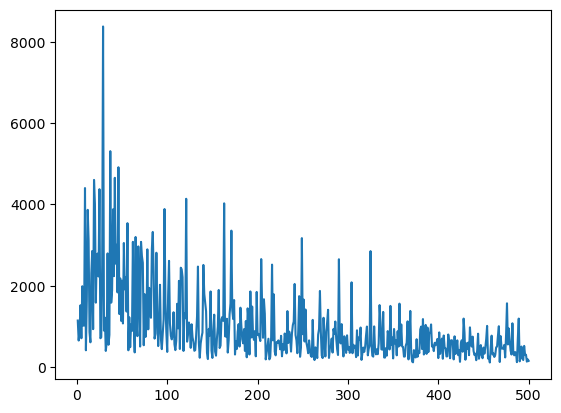

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Hyperparameters
n_training_episodes = 1000
gamma = 0.99
learning_rate = 0.00025/4  # 0.1
max_training_steps = 10000
eval_episodes = 10

# Exploration parameters
epsilon_max = 1
epsilon_min = 0.01

# replay memory parameters
replay_size = 100000
batch_size = 32


# fixed target network
fixed_target = True
copy_target = 30000


debug = True
double = True
dueling = True
prioritized = True

device = torch.device("cuda")
transform = scale_and_resize()

Experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

car = TrainMountainCar(n_training_episodes=n_training_episodes, gamma=gamma, learning_rate=learning_rate,
                       epsilon_max=epsilon_max, epsilon_min=epsilon_min,
                       max_steps=max_training_steps, batch_size=batch_size, fixed_target=fixed_target,
                       copy_target=copy_target, replay_size=replay_size, double=double, prioritized=prioritized,
                       debug=debug, dueling=dueling, eval_episodes=eval_episodes)

total_rewards, total_steps_list, q_measures, best_policy, evaluations = car.train()

torch.save(best_policy, 'data/Prioritized_Dueling_DDQN.pth')
np.savetxt(f'data/steps_Prioritized_Dueling_DDQN.txt', total_steps_list)
np.savetxt(f'data/q_values_Prioritized_Dueling_DDQN.txt', q_measures)
np.savetxt(f'data/eval_Prioritized_Dueling_DDQN.txt', evaluations)

plt.plot(np.arange(len(total_steps_list)) + 1, total_steps_list, zorder=-1, label='steps')
x = np.arange(50, n_training_episodes+1, 50)
plt.scatter(x, [-e for e in evaluations], color='r', marker='x', zorder=1, label='evaluations')
N = 10
steps_mean = running_mean(total_steps_list, N)
plt.plot(np.arange(len(steps_mean)) + 1, steps_mean, zorder=0, label='running average')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps per Episode - Prioritized_Dueling_DDQN')
plt.savefig('plots/steps_Prioritized_Dueling_DDQN.png')
plt.close()

plt.plot(np.arange(len(q_measures)) + 1, q_measures)
plt.xlabel('Episode')
plt.ylabel('Average Q')
plt.title('Average Q measure over sampled states')
plt.savefig('plots/q_measures_Prioritized_Dueling_DDQN.png')
plt.close()


Text(0.5, 1.0, 'Steps per Episode - Prioritized_Dueling_DDQN')

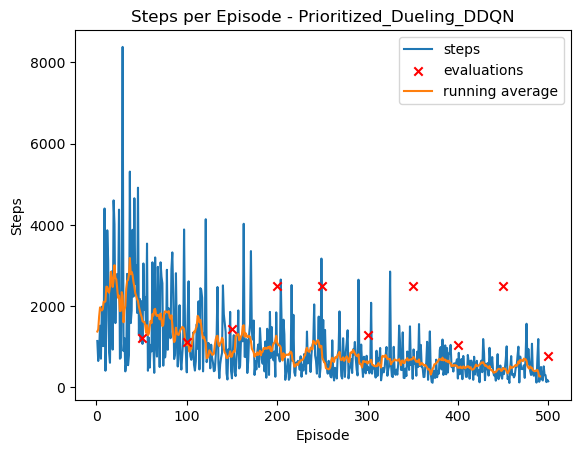

In [12]:
# plt.plot(np.arange(len(total_steps_list)) + 1, total_steps_list, zorder=-1, label='steps')
# plt.scatter([50, 100, 150, 200, 250, 300, 350, 400, 450, 500], [-e for e in evaluations], color='r', marker='x', zorder=1, label='evaluations')
# N = 10
# steps_mean = running_mean(total_steps_list, N)
# plt.plot(np.arange(len(steps_mean)) + 1, steps_mean, zorder=0, label='running average')
# plt.legend()
# plt.xlabel('Episode')
# plt.ylabel('Steps')
# plt.title('Steps per Episode - Prioritized_Dueling_DDQN')
# plt.savefig('plots/steps_Prioritized_Dueling_DDQN.png')
# plt.close()

# plt.plot(np.arange(len(q_measures)) + 1, q_measures)
# plt.xlabel('Episode')
# plt.ylabel('Average Q')
# plt.title('Average Q measure over sampled states')
# plt.savefig('plots/q_measures_Prioritized_Dueling_DDQN.png')
# plt.close()

               # old code
                    if self.prioritized:
                        beta = beta_by_frame(total_steps)
                        idxs, experiences, weights = experience_memory.sample(beta)
                        states, actions, rewards, next_states, terminations = (torch.Tensor(vs).to(device) for vs in
                                                                               zip(*experiences))
                        a = (actions.long().unsqueeze(dim=1))
                        r = rewards.unsqueeze(dim=1)
                        terminations = terminations.unsqueeze(dim=1)
                        mask = [i for i, x in enumerate(terminations) if not x]  # get all non-final states
                    else:
                        experiences = experience_memory.sample(self.batch_size)
                        experiences = np.asarray(experiences, dtype=object)
                        experience = experiences[:, 0]
                        experience = np.asarray([np.array(i, dtype=object) for i in experience])
                        states = experience[:, 0]
                        a = experience[:, 1]
                        r = experience[:, 2]
                        next_states = experience[:, 3]
                        terminations = experiences[:, 1]
                        mask = [i for i, x in enumerate(terminations) if not x]     # get all non-final states

                        # change states and rewards back to tensors
                        states = np.vstack(states).astype(np.float32)
                        states = torch.from_numpy(states)
                        next_states = np.vstack(next_states).astype(np.float32)
                        next_states = torch.from_numpy(next_states)
                        r = np.vstack(r).astype(np.float32)
                        r = torch.from_numpy(r).to(device)
                        a = np.vstack(a).astype(np.float32)
                        a = torch.from_numpy(a).to(device)
                        states = torch.reshape(states, (32, 4, 84, 84)).to(device)      # 80,120
                        next_states = torch.reshape(next_states, (32, 4, 84, 84)).to(device)

## Dueling Noisy

In [26]:
# Hyperparameters
n_training_episodes = 1000
gamma = 0.99
learning_rate = 0.00025  # 0.1
max_training_steps = 10000

# Exploration parameters
epsilon_max = 1
epsilon_min = 0.01
decay_rate = 0.00001

# replay memory parameters
replay_size = 100000
batch_size = 32


# fixed target network
fixed_target = True
copy_target = 30000


debug = True
double = True
noisy = True
dueling = True

Experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

car = TrainMountainCar(n_training_episodes=n_training_episodes, gamma=gamma, learning_rate=learning_rate,
                       epsilon_max=epsilon_max, epsilon_min=epsilon_min, decay_rate=decay_rate,
                       max_steps=max_training_steps, batch_size=batch_size, fixed_target=fixed_target, dueling=dueling,
                       copy_target=copy_target, replay_size=replay_size, double=double, debug=debug, noisy=noisy)

total_rewards, total_steps_list, q_measures, best_policy, evaluations = car.train()

# Save best policy, as well as steps and q measures
torch.save(best_policy, 'data/Noisy_Dueling_DDQN.pth')
np.savetxt(f'data/steps_Noisy_Dueling_DDQN.txt', total_steps_list)
np.savetxt(f'data/q_values_Noisy_Dueling_DDQN.txt', q_measures)
np.savetxt(f'data/eval_Noisy_Dueling_DDQN.txt', evaluations)

# Plot steps over episodes
plt.plot(np.arange(len(total_steps_list)) + 1, total_steps_list, zorder=0, label='training')
plt.scatter([50, 100, 150, 200, 250, 300, 350, 400, 450, 500], [-e for e in evaluations], color='r', marker='x', zorder=1, label='evaluations')
N = 10
steps_mean = running_mean(total_steps_list, N)
plt.plot(np.arange(len(steps_mean)) + 1, steps_mean, zorder=0, label='running average')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps per Episode - Noisy_Dueling_DDQN')
plt.savefig('plots/steps_Noisy_Dueling_DDQN.png')
plt.close()

# Plot Q measures over episodes
plt.plot(np.arange(len(q_measures)) + 1, q_measures)
plt.xlabel('Episode')
plt.ylabel('Average Q')
plt.title('Average Q measure over sampled states')
plt.savefig('plots/q_measures_Noisy_Dueling_DDQN.png')
plt.close()


TypeError: data type 'experience' not understood

## Prioritized Noisy Dueling DDQN

episode: 001	 steps: 01281	 total steps:001281	 epsilon: 1.00	 average Q: -0.777
episode: 002	 steps: 02993	 total steps:004273	 epsilon: 0.99	 average Q: -0.863
episode: 003	 steps: 02277	 total steps:006549	 epsilon: 0.99	 average Q: -0.825
episode: 004	 steps: 00617	 total steps:007165	 epsilon: 0.99	 average Q: -0.619
episode: 005	 steps: 01153	 total steps:008317	 epsilon: 0.98	 average Q: -0.982
episode: 006	 steps: 02437	 total steps:010753	 epsilon: 0.98	 average Q: -0.867
episode: 007	 steps: 04101	 total steps:014853	 epsilon: 0.97	 average Q: -0.915
episode: 008	 steps: 06837	 total steps:021689	 epsilon: 0.96	 average Q: -0.777
episode: 009	 steps: 00769	 total steps:022457	 epsilon: 0.96	 average Q: -0.695
episode: 010	 steps: 01765	 total steps:024221	 epsilon: 0.95	 average Q: -1.035
episode: 011	 steps: 01361	 total steps:025581	 epsilon: 0.95	 average Q: -0.881
episode: 012	 steps: 01413	 total steps:026993	 epsilon: 0.95	 average Q: -0.861
episode: 013	 steps: 00893	 

episode: 102	 steps: 00825	 total steps:220853	 epsilon: 0.56	 average Q: -9.954
episode: 103	 steps: 01169	 total steps:222021	 epsilon: 0.56	 average Q: -9.713
episode: 104	 steps: 01773	 total steps:223793	 epsilon: 0.56	 average Q: -10.644
episode: 105	 steps: 01461	 total steps:225253	 epsilon: 0.55	 average Q: -9.285
episode: 106	 steps: 01589	 total steps:226841	 epsilon: 0.55	 average Q: -8.966
episode: 107	 steps: 01257	 total steps:228097	 epsilon: 0.55	 average Q: -10.654
episode: 108	 steps: 02429	 total steps:230525	 epsilon: 0.54	 average Q: -10.214
episode: 109	 steps: 01485	 total steps:232009	 epsilon: 0.54	 average Q: -12.390
episode: 110	 steps: 01293	 total steps:233301	 epsilon: 0.54	 average Q: -9.896
episode: 111	 steps: 00681	 total steps:233981	 epsilon: 0.54	 average Q: -13.314
episode: 112	 steps: 02225	 total steps:236205	 epsilon: 0.53	 average Q: -12.354
episode: 113	 steps: 02469	 total steps:238673	 epsilon: 0.53	 average Q: -9.515
episode: 114	 steps: 0

episode: 202	 steps: 02641	 total steps:359257	 epsilon: 0.29	 average Q: -7.461
episode: 203	 steps: 03097	 total steps:362353	 epsilon: 0.28	 average Q: -10.187
episode: 204	 steps: 00729	 total steps:363081	 epsilon: 0.28	 average Q: -12.873
episode: 205	 steps: 01229	 total steps:364309	 epsilon: 0.28	 average Q: -10.301
episode: 206	 steps: 00961	 total steps:365269	 epsilon: 0.28	 average Q: -8.515
episode: 207	 steps: 00245	 total steps:365513	 epsilon: 0.28	 average Q: -12.618
episode: 208	 steps: 01473	 total steps:366985	 epsilon: 0.27	 average Q: -10.338
episode: 209	 steps: 01785	 total steps:368769	 epsilon: 0.27	 average Q: -12.362
episode: 210	 steps: 00373	 total steps:369141	 epsilon: 0.27	 average Q: -7.871
episode: 211	 steps: 00345	 total steps:369485	 epsilon: 0.27	 average Q: -12.067
episode: 212	 steps: 00829	 total steps:370313	 epsilon: 0.27	 average Q: -11.314
episode: 213	 steps: 00773	 total steps:371085	 epsilon: 0.27	 average Q: -6.983
episode: 214	 steps:

episode: 302	 steps: 00417	 total steps:461429	 epsilon: 0.09	 average Q: -10.044
episode: 303	 steps: 01933	 total steps:463361	 epsilon: 0.08	 average Q: -9.429
episode: 304	 steps: 01905	 total steps:465265	 epsilon: 0.08	 average Q: -8.684
episode: 305	 steps: 01097	 total steps:466361	 epsilon: 0.08	 average Q: -9.374
episode: 306	 steps: 00993	 total steps:467353	 epsilon: 0.07	 average Q: -10.234
episode: 307	 steps: 00441	 total steps:467793	 epsilon: 0.07	 average Q: -7.770
episode: 308	 steps: 00261	 total steps:468053	 epsilon: 0.07	 average Q: -7.464
episode: 309	 steps: 01333	 total steps:469385	 epsilon: 0.07	 average Q: -9.886
episode: 310	 steps: 00905	 total steps:470289	 epsilon: 0.07	 average Q: -8.552
episode: 311	 steps: 01013	 total steps:471301	 epsilon: 0.07	 average Q: -9.691
episode: 312	 steps: 01513	 total steps:472813	 epsilon: 0.06	 average Q: -8.192
episode: 313	 steps: 00765	 total steps:473577	 epsilon: 0.06	 average Q: -10.486
episode: 314	 steps: 0092

episode: 402	 steps: 00385	 total steps:552125	 epsilon: 0.01	 average Q: -10.727
episode: 403	 steps: 00889	 total steps:553013	 epsilon: 0.01	 average Q: -17.651
episode: 404	 steps: 00477	 total steps:553489	 epsilon: 0.01	 average Q: -14.862
episode: 405	 steps: 00965	 total steps:554453	 epsilon: 0.01	 average Q: -12.675
episode: 406	 steps: 02093	 total steps:556545	 epsilon: 0.01	 average Q: -14.491
episode: 407	 steps: 00493	 total steps:557037	 epsilon: 0.01	 average Q: -12.904
episode: 408	 steps: 02017	 total steps:559053	 epsilon: 0.01	 average Q: -11.567
episode: 409	 steps: 00705	 total steps:559757	 epsilon: 0.01	 average Q: -15.945
episode: 410	 steps: 01473	 total steps:561229	 epsilon: 0.01	 average Q: -13.217
episode: 411	 steps: 01289	 total steps:562517	 epsilon: 0.01	 average Q: -14.660
episode: 412	 steps: 02181	 total steps:564697	 epsilon: 0.01	 average Q: -18.145
episode: 413	 steps: 00777	 total steps:565473	 epsilon: 0.01	 average Q: -13.967
episode: 414	 st

TypeError: bad operand type for unary -: 'list'

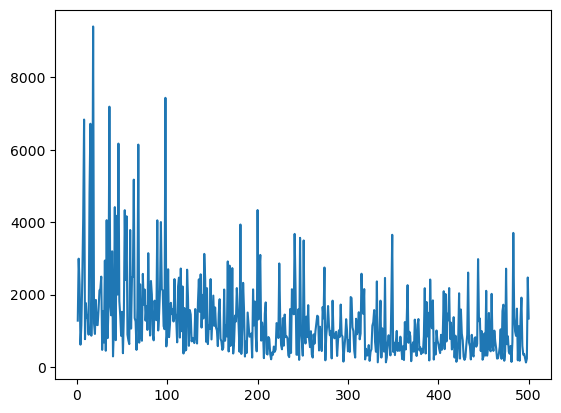

In [27]:
# Hyperparameters
n_training_episodes = 1000
gamma = 0.99
learning_rate = 0.00025  # 0.1
max_training_steps = 10000

# Exploration parameters
epsilon_max = 1
epsilon_min = 0.01
decay_rate = 0.00001

# replay memory parameters
replay_size = 100000
batch_size = 32


# fixed target network
fixed_target = True
copy_target = 30000


debug = True
double = True
noisy = True
dueling = True
prioritized = True

Experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

car = TrainMountainCar(n_training_episodes=n_training_episodes, gamma=gamma, learning_rate=learning_rate,
                       epsilon_max=epsilon_max, epsilon_min=epsilon_min, decay_rate=decay_rate,
                       max_steps=max_training_steps, batch_size=batch_size, fixed_target=fixed_target, dueling=dueling,
                       copy_target=copy_target, replay_size=replay_size, double=double, debug=debug, noisy=noisy,
                       prioritized=prioritized)

total_rewards, total_steps_list, q_measures, best_policy, evaluations = car.train()

# Save best policy, as well as steps and q measures
torch.save(best_policy, 'data/Noisy_Dueling_DDQN.pth')
np.savetxt(f'data/steps_Noisy_Dueling_DDQN.txt', total_steps_list)
np.savetxt(f'data/q_values_Noisy_Dueling_DDQN.txt', q_measures)
np.savetxt(f'data/eval_Noisy_Dueling_DDQN.txt', evaluations)

# Plot steps over episodes
plt.plot(np.arange(len(total_steps_list)) + 1, total_steps_list, zorder=0, label='training')
x = np.arange(50, n_training_episodes+1, 50)
plt.scatter(x, [-e for e in evaluations], color='r', marker='x', zorder=1, label='evaluations')
N = 10
steps_mean = running_mean(total_steps_list, N)
plt.plot(np.arange(len(steps_mean)) + 1, steps_mean, zorder=0, label='running average')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps per Episode - Noisy_Dueling_DDQN')
plt.savefig('plots/steps_Noisy_Dueling_DDQN.png')
plt.close()

# Plot Q measures over episodes
plt.plot(np.arange(len(q_measures)) + 1, q_measures)
plt.xlabel('Episode')
plt.ylabel('Average Q')
plt.title('Average Q measure over sampled states')
plt.savefig('plots/q_measures_Noisy_Dueling_DDQN.png')
plt.close()

## Prioritized Noisy

episode: 001	 steps: 06325	 total steps:006325	 epsilon: 0.99	 average Q: -0.734
episode: 002	 steps: 02165	 total steps:008489	 epsilon: 0.98	 average Q: -0.657
episode: 003	 steps: 03741	 total steps:012229	 epsilon: 0.98	 average Q: -0.764
episode: 004	 steps: 01725	 total steps:013953	 epsilon: 0.97	 average Q: -0.755
episode: 005	 steps: 00913	 total steps:014865	 epsilon: 0.97	 average Q: -0.908
episode: 006	 steps: 03665	 total steps:018529	 epsilon: 0.96	 average Q: -0.976
episode: 007	 steps: 01305	 total steps:019833	 epsilon: 0.96	 average Q: -0.259
episode: 008	 steps: 02049	 total steps:021881	 epsilon: 0.96	 average Q: -0.455
episode: 009	 steps: 04033	 total steps:025913	 epsilon: 0.95	 average Q: -0.548
episode: 010	 steps: 02941	 total steps:028853	 epsilon: 0.94	 average Q: -0.577
episode: 011	 steps: 01129	 total steps:029981	 epsilon: 0.94	 average Q: -0.553
episode: 012	 steps: 03733	 total steps:033713	 epsilon: 0.93	 average Q: -1.374
episode: 013	 steps: 02185	 

episode: 102	 steps: 01293	 total steps:211769	 epsilon: 0.58	 average Q: -6.887
episode: 103	 steps: 02929	 total steps:214697	 epsilon: 0.57	 average Q: -9.498
episode: 104	 steps: 00993	 total steps:215689	 epsilon: 0.57	 average Q: -7.996
episode: 105	 steps: 00841	 total steps:216529	 epsilon: 0.57	 average Q: -9.575
episode: 106	 steps: 00733	 total steps:217261	 epsilon: 0.57	 average Q: -10.948
episode: 107	 steps: 01065	 total steps:218325	 epsilon: 0.57	 average Q: -9.713
episode: 108	 steps: 00601	 total steps:218925	 epsilon: 0.57	 average Q: -6.318
episode: 109	 steps: 01101	 total steps:220025	 epsilon: 0.56	 average Q: -8.158
episode: 110	 steps: 01129	 total steps:221153	 epsilon: 0.56	 average Q: -8.096
episode: 111	 steps: 03365	 total steps:224517	 epsilon: 0.56	 average Q: -10.524
episode: 112	 steps: 01233	 total steps:225749	 epsilon: 0.55	 average Q: -9.134
episode: 113	 steps: 00597	 total steps:226345	 epsilon: 0.55	 average Q: -8.632
episode: 114	 steps: 00801

episode: 202	 steps: 02909	 total steps:337589	 epsilon: 0.33	 average Q: -10.639
episode: 203	 steps: 01893	 total steps:339481	 epsilon: 0.33	 average Q: -10.229
episode: 204	 steps: 00569	 total steps:340049	 epsilon: 0.33	 average Q: -9.480
episode: 205	 steps: 01861	 total steps:341909	 epsilon: 0.32	 average Q: -9.353
episode: 206	 steps: 01645	 total steps:343553	 epsilon: 0.32	 average Q: -11.385
episode: 207	 steps: 01325	 total steps:344877	 epsilon: 0.32	 average Q: -11.854
episode: 208	 steps: 01221	 total steps:346097	 epsilon: 0.31	 average Q: -11.522
episode: 209	 steps: 00429	 total steps:346525	 epsilon: 0.31	 average Q: -12.699
episode: 210	 steps: 02077	 total steps:348601	 epsilon: 0.31	 average Q: -9.139
episode: 211	 steps: 01341	 total steps:349941	 epsilon: 0.31	 average Q: -12.387
episode: 212	 steps: 01501	 total steps:351441	 epsilon: 0.30	 average Q: -11.858
episode: 213	 steps: 01581	 total steps:353021	 epsilon: 0.30	 average Q: -10.431
episode: 214	 steps

episode: 302	 steps: 00685	 total steps:445949	 epsilon: 0.12	 average Q: -13.476
episode: 303	 steps: 01333	 total steps:447281	 epsilon: 0.11	 average Q: -13.231
episode: 304	 steps: 01125	 total steps:448405	 epsilon: 0.11	 average Q: -16.202
episode: 305	 steps: 00393	 total steps:448797	 epsilon: 0.11	 average Q: -15.942
episode: 306	 steps: 00505	 total steps:449301	 epsilon: 0.11	 average Q: -15.226
episode: 307	 steps: 00505	 total steps:449805	 epsilon: 0.11	 average Q: -11.212
episode: 308	 steps: 00421	 total steps:450225	 epsilon: 0.11	 average Q: -13.182
episode: 309	 steps: 00433	 total steps:450657	 epsilon: 0.11	 average Q: -12.545
episode: 310	 steps: 00133	 total steps:450789	 epsilon: 0.11	 average Q: -14.072
episode: 311	 steps: 00737	 total steps:451525	 epsilon: 0.11	 average Q: -13.686
episode: 312	 steps: 00409	 total steps:451933	 epsilon: 0.11	 average Q: -18.270
episode: 313	 steps: 00337	 total steps:452269	 epsilon: 0.10	 average Q: -17.234
episode: 314	 st

episode: 402	 steps: 00397	 total steps:529485	 epsilon: 0.01	 average Q: -17.825
episode: 403	 steps: 01317	 total steps:530801	 epsilon: 0.01	 average Q: -23.025
episode: 404	 steps: 00421	 total steps:531221	 epsilon: 0.01	 average Q: -18.912
episode: 405	 steps: 00441	 total steps:531661	 epsilon: 0.01	 average Q: -20.844
episode: 406	 steps: 00941	 total steps:532601	 epsilon: 0.01	 average Q: -17.692
episode: 407	 steps: 00597	 total steps:533197	 epsilon: 0.01	 average Q: -15.025
episode: 408	 steps: 01465	 total steps:534661	 epsilon: 0.01	 average Q: -13.762
episode: 409	 steps: 00133	 total steps:534793	 epsilon: 0.01	 average Q: -20.000
episode: 410	 steps: 00897	 total steps:535689	 epsilon: 0.01	 average Q: -22.241
episode: 411	 steps: 00437	 total steps:536125	 epsilon: 0.01	 average Q: -18.421
episode: 412	 steps: 00637	 total steps:536761	 epsilon: 0.01	 average Q: -20.828
episode: 413	 steps: 00605	 total steps:537365	 epsilon: 0.01	 average Q: -13.887
episode: 414	 st

episode: 502	 steps: 00897	 total steps:606209	 epsilon: 0.01	 average Q: -16.320
episode: 503	 steps: 00305	 total steps:606513	 epsilon: 0.01	 average Q: -15.537
episode: 504	 steps: 00769	 total steps:607281	 epsilon: 0.01	 average Q: -21.390
episode: 505	 steps: 00317	 total steps:607597	 epsilon: 0.01	 average Q: -14.120
episode: 506	 steps: 00429	 total steps:608025	 epsilon: 0.01	 average Q: -18.548
episode: 507	 steps: 00877	 total steps:608901	 epsilon: 0.01	 average Q: -16.468
episode: 508	 steps: 01849	 total steps:610749	 epsilon: 0.01	 average Q: -18.049
episode: 509	 steps: 00273	 total steps:611021	 epsilon: 0.01	 average Q: -20.806
episode: 510	 steps: 00285	 total steps:611305	 epsilon: 0.01	 average Q: -12.267
episode: 511	 steps: 00533	 total steps:611837	 epsilon: 0.01	 average Q: -12.791
episode: 512	 steps: 00393	 total steps:612229	 epsilon: 0.01	 average Q: -11.507
episode: 513	 steps: 00409	 total steps:612637	 epsilon: 0.01	 average Q: -16.756
episode: 514	 st

episode: 602	 steps: 00329	 total steps:678613	 epsilon: 0.01	 average Q: -16.072
episode: 603	 steps: 01541	 total steps:680153	 epsilon: 0.01	 average Q: -11.272
episode: 604	 steps: 00793	 total steps:680945	 epsilon: 0.01	 average Q: -13.151
episode: 605	 steps: 00713	 total steps:681657	 epsilon: 0.01	 average Q: -16.251
episode: 606	 steps: 00781	 total steps:682437	 epsilon: 0.01	 average Q: -14.274
episode: 607	 steps: 00289	 total steps:682725	 epsilon: 0.01	 average Q: -14.981
episode: 608	 steps: 00205	 total steps:682929	 epsilon: 0.01	 average Q: -15.754
episode: 609	 steps: 00317	 total steps:683245	 epsilon: 0.01	 average Q: -12.126
episode: 610	 steps: 00313	 total steps:683557	 epsilon: 0.01	 average Q: -12.388
episode: 611	 steps: 00285	 total steps:683841	 epsilon: 0.01	 average Q: -12.844
episode: 612	 steps: 01321	 total steps:685161	 epsilon: 0.01	 average Q: -9.429
episode: 613	 steps: 00765	 total steps:685925	 epsilon: 0.01	 average Q: -9.310
episode: 614	 step

episode: 702	 steps: 01341	 total steps:748545	 epsilon: 0.01	 average Q: -14.037
episode: 703	 steps: 00625	 total steps:749169	 epsilon: 0.01	 average Q: -12.693
episode: 704	 steps: 01353	 total steps:750521	 epsilon: 0.01	 average Q: -12.428
episode: 705	 steps: 00237	 total steps:750757	 epsilon: 0.01	 average Q: -12.586
episode: 706	 steps: 00193	 total steps:750949	 epsilon: 0.01	 average Q: -8.925
episode: 707	 steps: 00405	 total steps:751353	 epsilon: 0.01	 average Q: -13.590
episode: 708	 steps: 01061	 total steps:752413	 epsilon: 0.01	 average Q: -10.784
episode: 709	 steps: 00857	 total steps:753269	 epsilon: 0.01	 average Q: -16.707
episode: 710	 steps: 00333	 total steps:753601	 epsilon: 0.01	 average Q: -10.376
episode: 711	 steps: 00573	 total steps:754173	 epsilon: 0.01	 average Q: -15.390
episode: 712	 steps: 00221	 total steps:754393	 epsilon: 0.01	 average Q: -19.065
episode: 713	 steps: 00193	 total steps:754585	 epsilon: 0.01	 average Q: -12.304
episode: 714	 ste

episode: 802	 steps: 01125	 total steps:825533	 epsilon: 0.01	 average Q: -10.295
episode: 803	 steps: 00221	 total steps:825753	 epsilon: 0.01	 average Q: -8.992
episode: 804	 steps: 00897	 total steps:826649	 epsilon: 0.01	 average Q: -12.653
episode: 805	 steps: 01197	 total steps:827845	 epsilon: 0.01	 average Q: -9.673
episode: 806	 steps: 00201	 total steps:828045	 epsilon: 0.01	 average Q: -12.417
episode: 807	 steps: 01253	 total steps:829297	 epsilon: 0.01	 average Q: -10.773
episode: 808	 steps: 02065	 total steps:831361	 epsilon: 0.01	 average Q: -12.395
episode: 809	 steps: 00649	 total steps:832009	 epsilon: 0.01	 average Q: -11.741
episode: 810	 steps: 00557	 total steps:832565	 epsilon: 0.01	 average Q: -17.161
episode: 811	 steps: 00473	 total steps:833037	 epsilon: 0.01	 average Q: -12.401
episode: 812	 steps: 01377	 total steps:834413	 epsilon: 0.01	 average Q: -9.419
episode: 813	 steps: 00409	 total steps:834821	 epsilon: 0.01	 average Q: -11.556
episode: 814	 steps

episode: 902	 steps: 00877	 total steps:906741	 epsilon: 0.01	 average Q: -12.795
episode: 903	 steps: 01469	 total steps:908209	 epsilon: 0.01	 average Q: -12.432
episode: 904	 steps: 00485	 total steps:908693	 epsilon: 0.01	 average Q: -12.955
episode: 905	 steps: 01261	 total steps:909953	 epsilon: 0.01	 average Q: -10.688
episode: 906	 steps: 00433	 total steps:910385	 epsilon: 0.01	 average Q: -6.309
episode: 907	 steps: 00381	 total steps:910765	 epsilon: 0.01	 average Q: -15.747
episode: 908	 steps: 01157	 total steps:911921	 epsilon: 0.01	 average Q: -10.394
episode: 909	 steps: 00829	 total steps:912749	 epsilon: 0.01	 average Q: -12.992
episode: 910	 steps: 00213	 total steps:912961	 epsilon: 0.01	 average Q: -12.355
episode: 911	 steps: 01617	 total steps:914577	 epsilon: 0.01	 average Q: -8.016
episode: 912	 steps: 01949	 total steps:916525	 epsilon: 0.01	 average Q: -9.306
episode: 913	 steps: 01249	 total steps:917773	 epsilon: 0.01	 average Q: -10.244
episode: 914	 steps

ValueError: x and y must be the same size

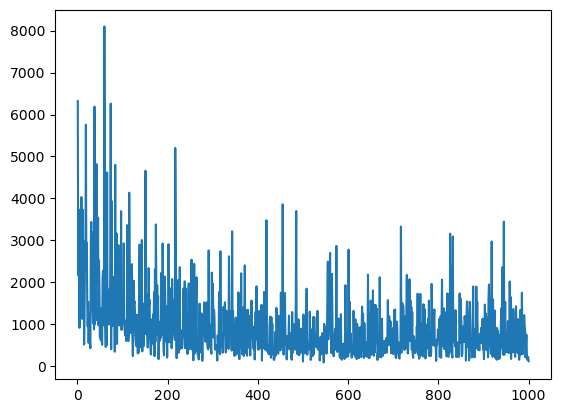

In [30]:
# Hyperparameters
n_training_episodes = 1000
gamma = 0.99
learning_rate = 0.00025  # 0.1
max_training_steps = 10000

# Exploration parameters
epsilon_max = 1
epsilon_min = 0.01
decay_rate = 0.00001

# replay memory parameters
replay_size = 100000
batch_size = 32


# fixed target network
fixed_target = True
copy_target = 30000


debug = True
double = True
noisy = True
prioritized = True

Experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

car = TrainMountainCar(n_training_episodes=n_training_episodes, gamma=gamma, learning_rate=learning_rate,
                       epsilon_max=epsilon_max, epsilon_min=epsilon_min, decay_rate=decay_rate,
                       max_steps=max_training_steps, batch_size=batch_size, fixed_target=fixed_target, dueling=dueling,
                       copy_target=copy_target, replay_size=replay_size, double=double, debug=debug, noisy=noisy,
                       prioritized=prioritized)

total_rewards, total_steps_list, q_measures, best_policy, evaluations = car.train()

# Save best policy, as well as steps and q measures
torch.save(best_policy, 'data/Prioritized_Noisy_DDQN.pth')
np.savetxt(f'data/steps_Prioritized_Noisy_DDQN.txt', total_steps_list)
np.savetxt(f'data/q_values_Prioritized_Noisy_DDQN1.txt', q_measures)
np.savetxt(f'data/eval_Prioritized_Noisy_DDQN1.txt', evaluations)

# Plot steps over episodes
plt.plot(np.arange(len(total_steps_list)) + 1, total_steps_list, zorder=0, label='training')
x = np.arange(50, n_training_episodes+1, 50)
plt.scatter(x, [-e for e in evaluations], color='r', marker='x', zorder=1, label='evaluations')
N = 10
steps_mean = running_mean(total_steps_list, N)
plt.plot(np.arange(len(steps_mean)) + 1, steps_mean, zorder=0, label='running average')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps per Episode - Prioritized Noisy DDQN')
plt.savefig('plots/steps_Prioritized_Noisy_DDQN.png')
plt.close()

# Plot Q measures over episodes
plt.plot(np.arange(len(q_measures)) + 1, q_measures)
plt.xlabel('Episode')
plt.ylabel('Average Q')
plt.title('Average Q measure over sampled states')
plt.savefig('plots/q_measures_Prioritized_Noisy_DDQN.png')
plt.close()

## Dueling Noisy

episode: 001	 steps: 02437	 total steps:002437	 epsilon: 1.00	 average Q: -0.523
episode: 002	 steps: 02373	 total steps:004809	 epsilon: 0.99	 average Q: -0.903
episode: 003	 steps: 00781	 total steps:005589	 epsilon: 0.99	 average Q: -3.360
episode: 004	 steps: 02657	 total steps:008245	 epsilon: 0.98	 average Q: -0.936
episode: 005	 steps: 03197	 total steps:011441	 epsilon: 0.98	 average Q: -1.096
episode: 006	 steps: 01017	 total steps:012457	 epsilon: 0.98	 average Q: -1.145
episode: 007	 steps: 00701	 total steps:013157	 epsilon: 0.97	 average Q: -0.884
episode: 008	 steps: 01405	 total steps:014561	 epsilon: 0.97	 average Q: -0.718
episode: 009	 steps: 02213	 total steps:016773	 epsilon: 0.97	 average Q: -0.649
episode: 010	 steps: 01093	 total steps:017865	 epsilon: 0.96	 average Q: -0.802
episode: 011	 steps: 01601	 total steps:019465	 epsilon: 0.96	 average Q: -0.843
episode: 012	 steps: 02349	 total steps:021813	 epsilon: 0.96	 average Q: -0.287
episode: 013	 steps: 01045	 

episode: 102	 steps: 08573	 total steps:194173	 epsilon: 0.62	 average Q: -6.396
episode: 103	 steps: 03029	 total steps:197201	 epsilon: 0.61	 average Q: -8.538
episode: 104	 steps: 03097	 total steps:200297	 epsilon: 0.60	 average Q: -6.827
episode: 105	 steps: 00645	 total steps:200941	 epsilon: 0.60	 average Q: -7.057
episode: 106	 steps: 01493	 total steps:202433	 epsilon: 0.60	 average Q: -7.522
episode: 107	 steps: 04325	 total steps:206757	 epsilon: 0.59	 average Q: -8.241
episode: 108	 steps: 01777	 total steps:208533	 epsilon: 0.59	 average Q: -5.761
episode: 109	 steps: 00981	 total steps:209513	 epsilon: 0.59	 average Q: -6.047
episode: 110	 steps: 01101	 total steps:210613	 epsilon: 0.58	 average Q: -8.420
episode: 111	 steps: 05521	 total steps:216133	 epsilon: 0.57	 average Q: -14.303
episode: 112	 steps: 00569	 total steps:216701	 epsilon: 0.57	 average Q: -18.974
episode: 113	 steps: 02601	 total steps:219301	 epsilon: 0.57	 average Q: -11.051
episode: 114	 steps: 0056

episode: 202	 steps: 01229	 total steps:369129	 epsilon: 0.27	 average Q: -32.861
episode: 203	 steps: 01097	 total steps:370225	 epsilon: 0.27	 average Q: -35.816
episode: 204	 steps: 02569	 total steps:372793	 epsilon: 0.26	 average Q: -45.527
episode: 205	 steps: 01861	 total steps:374653	 epsilon: 0.26	 average Q: -44.474
episode: 206	 steps: 01461	 total steps:376113	 epsilon: 0.26	 average Q: -32.863
episode: 207	 steps: 00601	 total steps:376713	 epsilon: 0.25	 average Q: -46.625
episode: 208	 steps: 00517	 total steps:377229	 epsilon: 0.25	 average Q: -36.008
episode: 209	 steps: 00981	 total steps:378209	 epsilon: 0.25	 average Q: -39.154
episode: 210	 steps: 00201	 total steps:378409	 epsilon: 0.25	 average Q: -35.382
episode: 211	 steps: 01637	 total steps:380045	 epsilon: 0.25	 average Q: -38.607
episode: 212	 steps: 00357	 total steps:380401	 epsilon: 0.25	 average Q: -42.676
episode: 213	 steps: 00617	 total steps:381017	 epsilon: 0.25	 average Q: -37.044
episode: 214	 st

episode: 302	 steps: 00721	 total steps:455837	 epsilon: 0.10	 average Q: -47.915
episode: 303	 steps: 01029	 total steps:456865	 epsilon: 0.10	 average Q: -38.914
episode: 304	 steps: 00393	 total steps:457257	 epsilon: 0.09	 average Q: -54.015
episode: 305	 steps: 01697	 total steps:458953	 epsilon: 0.09	 average Q: -44.864
episode: 306	 steps: 00693	 total steps:459645	 epsilon: 0.09	 average Q: -41.306
episode: 307	 steps: 00541	 total steps:460185	 epsilon: 0.09	 average Q: -50.099
episode: 308	 steps: 00693	 total steps:460877	 epsilon: 0.09	 average Q: -42.225
episode: 309	 steps: 03989	 total steps:464865	 epsilon: 0.08	 average Q: -44.006
episode: 310	 steps: 02913	 total steps:467777	 epsilon: 0.07	 average Q: -48.877
episode: 311	 steps: 00801	 total steps:468577	 epsilon: 0.07	 average Q: -43.627
episode: 312	 steps: 00621	 total steps:469197	 epsilon: 0.07	 average Q: -54.608
episode: 313	 steps: 00857	 total steps:470053	 epsilon: 0.07	 average Q: -56.316
episode: 314	 st

episode: 402	 steps: 00137	 total steps:546253	 epsilon: 0.01	 average Q: -36.560
episode: 403	 steps: 01209	 total steps:547461	 epsilon: 0.01	 average Q: -29.829
episode: 404	 steps: 00361	 total steps:547821	 epsilon: 0.01	 average Q: -42.669
episode: 405	 steps: 00233	 total steps:548053	 epsilon: 0.01	 average Q: -34.627
episode: 406	 steps: 00493	 total steps:548545	 epsilon: 0.01	 average Q: -34.068
episode: 407	 steps: 00301	 total steps:548845	 epsilon: 0.01	 average Q: -28.477
episode: 408	 steps: 00561	 total steps:549405	 epsilon: 0.01	 average Q: -27.782
episode: 409	 steps: 00373	 total steps:549777	 epsilon: 0.01	 average Q: -35.049
episode: 410	 steps: 00237	 total steps:550013	 epsilon: 0.01	 average Q: -26.308
episode: 411	 steps: 00405	 total steps:550417	 epsilon: 0.01	 average Q: -43.322
episode: 412	 steps: 01005	 total steps:551421	 epsilon: 0.01	 average Q: -40.355
episode: 413	 steps: 00261	 total steps:551681	 epsilon: 0.01	 average Q: -34.949
episode: 414	 st

episode: 502	 steps: 00433	 total steps:620493	 epsilon: 0.01	 average Q: -44.256
episode: 503	 steps: 00401	 total steps:620893	 epsilon: 0.01	 average Q: -45.629
episode: 504	 steps: 00733	 total steps:621625	 epsilon: 0.01	 average Q: -43.065
episode: 505	 steps: 00585	 total steps:622209	 epsilon: 0.01	 average Q: -40.760
episode: 506	 steps: 00353	 total steps:622561	 epsilon: 0.01	 average Q: -38.949
episode: 507	 steps: 00661	 total steps:623221	 epsilon: 0.01	 average Q: -43.285
episode: 508	 steps: 01065	 total steps:624285	 epsilon: 0.01	 average Q: -61.935
episode: 509	 steps: 00393	 total steps:624677	 epsilon: 0.01	 average Q: -35.477
episode: 510	 steps: 00641	 total steps:625317	 epsilon: 0.01	 average Q: -33.937
episode: 511	 steps: 01941	 total steps:627257	 epsilon: 0.01	 average Q: -29.658
episode: 512	 steps: 00361	 total steps:627617	 epsilon: 0.01	 average Q: -40.734
episode: 513	 steps: 01081	 total steps:628697	 epsilon: 0.01	 average Q: -41.151
episode: 514	 st

episode: 602	 steps: 00389	 total steps:694677	 epsilon: 0.01	 average Q: -48.017
episode: 603	 steps: 01245	 total steps:695921	 epsilon: 0.01	 average Q: -55.089
episode: 604	 steps: 00453	 total steps:696373	 epsilon: 0.01	 average Q: -49.479
episode: 605	 steps: 01745	 total steps:698117	 epsilon: 0.01	 average Q: -53.943
episode: 606	 steps: 00977	 total steps:699093	 epsilon: 0.01	 average Q: -50.199
episode: 607	 steps: 00709	 total steps:699801	 epsilon: 0.01	 average Q: -56.758
episode: 608	 steps: 00209	 total steps:700009	 epsilon: 0.01	 average Q: -58.485
episode: 609	 steps: 00205	 total steps:700213	 epsilon: 0.01	 average Q: -59.448
episode: 610	 steps: 01117	 total steps:701329	 epsilon: 0.01	 average Q: -46.909
episode: 611	 steps: 00965	 total steps:702293	 epsilon: 0.01	 average Q: -44.802
episode: 612	 steps: 00577	 total steps:702869	 epsilon: 0.01	 average Q: -61.840
episode: 613	 steps: 00593	 total steps:703461	 epsilon: 0.01	 average Q: -56.728
episode: 614	 st

episode: 702	 steps: 01809	 total steps:781037	 epsilon: 0.01	 average Q: -75.336
episode: 703	 steps: 00249	 total steps:781285	 epsilon: 0.01	 average Q: -46.347
episode: 704	 steps: 00261	 total steps:781545	 epsilon: 0.01	 average Q: -79.097
episode: 705	 steps: 01985	 total steps:783529	 epsilon: 0.01	 average Q: -55.680
episode: 706	 steps: 00517	 total steps:784045	 epsilon: 0.01	 average Q: -71.270
episode: 707	 steps: 00881	 total steps:784925	 epsilon: 0.01	 average Q: -62.625
episode: 708	 steps: 01157	 total steps:786081	 epsilon: 0.01	 average Q: -78.944
episode: 709	 steps: 00437	 total steps:786517	 epsilon: 0.01	 average Q: -55.074
episode: 710	 steps: 00549	 total steps:787065	 epsilon: 0.01	 average Q: -65.334
episode: 711	 steps: 01101	 total steps:788165	 epsilon: 0.01	 average Q: -57.527
episode: 712	 steps: 00385	 total steps:788549	 epsilon: 0.01	 average Q: -72.800
episode: 713	 steps: 00669	 total steps:789217	 epsilon: 0.01	 average Q: -57.299
episode: 714	 st

episode: 802	 steps: 00741	 total steps:852397	 epsilon: 0.01	 average Q: -52.588
episode: 803	 steps: 00589	 total steps:852985	 epsilon: 0.01	 average Q: -52.674
episode: 804	 steps: 00505	 total steps:853489	 epsilon: 0.01	 average Q: -47.984
episode: 805	 steps: 00289	 total steps:853777	 epsilon: 0.01	 average Q: -74.021
episode: 806	 steps: 02157	 total steps:855933	 epsilon: 0.01	 average Q: -56.099
episode: 807	 steps: 00565	 total steps:856497	 epsilon: 0.01	 average Q: -50.259
episode: 808	 steps: 00581	 total steps:857077	 epsilon: 0.01	 average Q: -56.855
episode: 809	 steps: 00301	 total steps:857377	 epsilon: 0.01	 average Q: -47.188
episode: 810	 steps: 01445	 total steps:858821	 epsilon: 0.01	 average Q: -56.788
episode: 811	 steps: 01401	 total steps:860221	 epsilon: 0.01	 average Q: -52.038
episode: 812	 steps: 00253	 total steps:860473	 epsilon: 0.01	 average Q: -48.401
episode: 813	 steps: 00405	 total steps:860877	 epsilon: 0.01	 average Q: -57.995
episode: 814	 st

episode: 902	 steps: 00369	 total steps:933229	 epsilon: 0.01	 average Q: -36.495
episode: 903	 steps: 01745	 total steps:934973	 epsilon: 0.01	 average Q: -35.892
episode: 904	 steps: 00233	 total steps:935205	 epsilon: 0.01	 average Q: -38.347
episode: 905	 steps: 01377	 total steps:936581	 epsilon: 0.01	 average Q: -38.592
episode: 906	 steps: 00589	 total steps:937169	 epsilon: 0.01	 average Q: -32.196
episode: 907	 steps: 01049	 total steps:938217	 epsilon: 0.01	 average Q: -40.122
episode: 908	 steps: 01753	 total steps:939969	 epsilon: 0.01	 average Q: -41.428
episode: 909	 steps: 00297	 total steps:940265	 epsilon: 0.01	 average Q: -38.147
episode: 910	 steps: 00781	 total steps:941045	 epsilon: 0.01	 average Q: -32.342
episode: 911	 steps: 01025	 total steps:942069	 epsilon: 0.01	 average Q: -37.236
episode: 912	 steps: 00725	 total steps:942793	 epsilon: 0.01	 average Q: -32.528
episode: 913	 steps: 00229	 total steps:943021	 epsilon: 0.01	 average Q: -30.856
episode: 914	 st

ValueError: x and y must be the same size

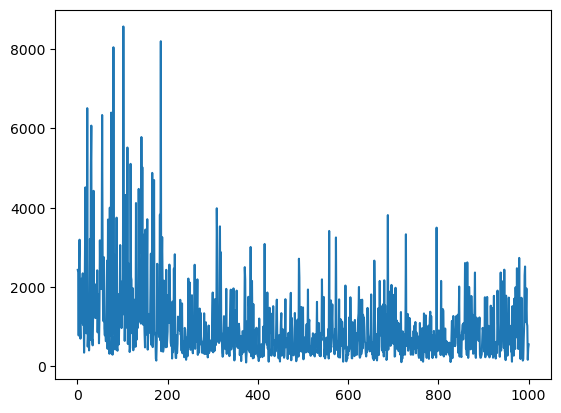

In [43]:
# Hyperparameters
n_training_episodes = 1000
gamma = 0.99
learning_rate = 0.00025  # 0.1
max_training_steps = 10000

# Exploration parameters
epsilon_max = 1
epsilon_min = 0.01
decay_rate = 0.00001

# replay memory parameters
replay_size = 100000
batch_size = 32


# fixed target network
fixed_target = True
copy_target = 30000


debug = True
double = True
noisy = True
dueling = True

Experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

car = TrainMountainCar(n_training_episodes=n_training_episodes, gamma=gamma, learning_rate=learning_rate,
                       epsilon_max=epsilon_max, epsilon_min=epsilon_min, decay_rate=decay_rate,
                       max_steps=max_training_steps, batch_size=batch_size, fixed_target=fixed_target, dueling=dueling,
                       copy_target=copy_target, replay_size=replay_size, double=double, debug=debug, noisy=noisy)

total_rewards, total_steps_list, q_measures, best_policy, evaluations = car.train()

# Save best policy, as well as steps and q measures
torch.save(best_policy, 'data/Noisy_Dueling_DDQN.pth')
np.savetxt(f'data/steps_Noisy_Dueling_DDQN.txt', total_steps_list)
np.savetxt(f'data/q_values_Noisy_Dueling_DDQN.txt', q_measures)
np.savetxt(f'data/eval_Noisy_Dueling_DDQN.txt', evaluations)

# Plot steps over episodes
plt.plot(np.arange(len(total_steps_list)) + 1, total_steps_list, zorder=0, label='training')
x = np.arange(50, n_training_episodes+1, 50)
plt.scatter(x, [-e for e in evaluations], color='r', marker='x', zorder=1, label='evaluations')
N = 10
steps_mean = running_mean(total_steps_list, N)
plt.plot(np.arange(len(steps_mean)) + 1, steps_mean, zorder=0, label='running average')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps per Episode - Noisy_Dueling_DDQN')
plt.savefig('plots/steps_Noisy_Dueling_DDQN.png')
plt.close()

# Plot Q measures over episodes
plt.plot(np.arange(len(q_measures)) + 1, q_measures)
plt.xlabel('Episode')
plt.ylabel('Average Q')
plt.title('Average Q measure over sampled states')
plt.savefig('plots/q_measures_Noisy_Dueling_DDQN.png')
plt.close()


## Dueling DDQN

episode: 001	 steps: 00845	 total steps:000845	 epsilon: 1.00	 average Q: -0.926
episode: 002	 steps: 02037	 total steps:002881	 epsilon: 0.99	 average Q: -1.017
episode: 003	 steps: 01861	 total steps:004741	 epsilon: 0.99	 average Q: -1.007
episode: 004	 steps: 02065	 total steps:006805	 epsilon: 0.99	 average Q: -1.014
episode: 005	 steps: 00797	 total steps:007601	 epsilon: 0.98	 average Q: -0.930
episode: 006	 steps: 01577	 total steps:009177	 epsilon: 0.98	 average Q: -0.995
episode: 007	 steps: 10001	 total steps:019177	 epsilon: 0.96	 average Q: -0.983
episode: 008	 steps: 03753	 total steps:022929	 epsilon: 0.95	 average Q: -1.018
episode: 009	 steps: 02489	 total steps:025417	 epsilon: 0.95	 average Q: -0.996
episode: 010	 steps: 00653	 total steps:026069	 epsilon: 0.95	 average Q: -1.019
episode: 011	 steps: 01453	 total steps:027521	 epsilon: 0.95	 average Q: -0.967
episode: 012	 steps: 00825	 total steps:028345	 epsilon: 0.94	 average Q: -0.998
episode: 013	 steps: 02593	 

episode: 102	 steps: 02309	 total steps:231877	 epsilon: 0.54	 average Q: -8.870
episode: 103	 steps: 00801	 total steps:232677	 epsilon: 0.54	 average Q: -8.651
episode: 104	 steps: 00761	 total steps:233437	 epsilon: 0.54	 average Q: -9.133
episode: 105	 steps: 00685	 total steps:234121	 epsilon: 0.54	 average Q: -9.172
episode: 106	 steps: 01505	 total steps:235625	 epsilon: 0.53	 average Q: -8.639
episode: 107	 steps: 01269	 total steps:236893	 epsilon: 0.53	 average Q: -8.097
episode: 108	 steps: 00781	 total steps:237673	 epsilon: 0.53	 average Q: -8.062
episode: 109	 steps: 04621	 total steps:242293	 epsilon: 0.52	 average Q: -10.539
episode: 110	 steps: 00725	 total steps:243017	 epsilon: 0.52	 average Q: -12.269
episode: 111	 steps: 01413	 total steps:244429	 epsilon: 0.52	 average Q: -11.351
episode: 112	 steps: 03625	 total steps:248053	 epsilon: 0.51	 average Q: -10.220
episode: 113	 steps: 01953	 total steps:250005	 epsilon: 0.50	 average Q: -11.367
episode: 114	 steps: 01

episode: 202	 steps: 00853	 total steps:376901	 epsilon: 0.25	 average Q: -11.912
episode: 203	 steps: 00613	 total steps:377513	 epsilon: 0.25	 average Q: -13.029
episode: 204	 steps: 01021	 total steps:378533	 epsilon: 0.25	 average Q: -12.044
episode: 205	 steps: 00653	 total steps:379185	 epsilon: 0.25	 average Q: -12.631
episode: 206	 steps: 01065	 total steps:380249	 epsilon: 0.25	 average Q: -11.898
episode: 207	 steps: 01261	 total steps:381509	 epsilon: 0.24	 average Q: -13.661
episode: 208	 steps: 01621	 total steps:383129	 epsilon: 0.24	 average Q: -11.648
episode: 209	 steps: 00953	 total steps:384081	 epsilon: 0.24	 average Q: -12.102
episode: 210	 steps: 00745	 total steps:384825	 epsilon: 0.24	 average Q: -12.990
episode: 211	 steps: 00945	 total steps:385769	 epsilon: 0.24	 average Q: -12.810
episode: 212	 steps: 00469	 total steps:386237	 epsilon: 0.24	 average Q: -13.130
episode: 213	 steps: 00333	 total steps:386569	 epsilon: 0.23	 average Q: -13.290
episode: 214	 st

episode: 302	 steps: 01249	 total steps:484889	 epsilon: 0.04	 average Q: -18.123
episode: 303	 steps: 00521	 total steps:485409	 epsilon: 0.04	 average Q: -17.496
episode: 304	 steps: 00433	 total steps:485841	 epsilon: 0.04	 average Q: -21.291
episode: 305	 steps: 00233	 total steps:486073	 epsilon: 0.04	 average Q: -18.222
episode: 306	 steps: 01077	 total steps:487149	 epsilon: 0.04	 average Q: -21.459
episode: 307	 steps: 01629	 total steps:488777	 epsilon: 0.03	 average Q: -17.955
episode: 308	 steps: 01641	 total steps:490417	 epsilon: 0.03	 average Q: -17.822
episode: 309	 steps: 00649	 total steps:491065	 epsilon: 0.03	 average Q: -19.051
episode: 310	 steps: 01365	 total steps:492429	 epsilon: 0.03	 average Q: -18.152
episode: 311	 steps: 02093	 total steps:494521	 epsilon: 0.02	 average Q: -19.761
episode: 312	 steps: 00357	 total steps:494877	 epsilon: 0.02	 average Q: -19.123
episode: 313	 steps: 02545	 total steps:497421	 epsilon: 0.02	 average Q: -19.596
episode: 314	 st

episode: 402	 steps: 01513	 total steps:578205	 epsilon: 0.01	 average Q: -30.597
episode: 403	 steps: 01037	 total steps:579241	 epsilon: 0.01	 average Q: -28.116
episode: 404	 steps: 01045	 total steps:580285	 epsilon: 0.01	 average Q: -28.592
episode: 405	 steps: 01589	 total steps:581873	 epsilon: 0.01	 average Q: -25.139
episode: 406	 steps: 00305	 total steps:582177	 epsilon: 0.01	 average Q: -26.144
episode: 407	 steps: 02525	 total steps:584701	 epsilon: 0.01	 average Q: -25.971
episode: 408	 steps: 00777	 total steps:585477	 epsilon: 0.01	 average Q: -30.389
episode: 409	 steps: 01489	 total steps:586965	 epsilon: 0.01	 average Q: -27.713
episode: 410	 steps: 00361	 total steps:587325	 epsilon: 0.01	 average Q: -30.439
episode: 411	 steps: 01513	 total steps:588837	 epsilon: 0.01	 average Q: -27.702
episode: 412	 steps: 00885	 total steps:589721	 epsilon: 0.01	 average Q: -25.558
episode: 413	 steps: 00257	 total steps:589977	 epsilon: 0.01	 average Q: -27.313
episode: 414	 st

episode: 502	 steps: 00785	 total steps:666149	 epsilon: 0.01	 average Q: -35.140
episode: 503	 steps: 01373	 total steps:667521	 epsilon: 0.01	 average Q: -38.362
episode: 504	 steps: 01069	 total steps:668589	 epsilon: 0.01	 average Q: -32.532
episode: 505	 steps: 03789	 total steps:672377	 epsilon: 0.01	 average Q: -34.585
episode: 506	 steps: 01325	 total steps:673701	 epsilon: 0.01	 average Q: -36.055
episode: 507	 steps: 00233	 total steps:673933	 epsilon: 0.01	 average Q: -33.863
episode: 508	 steps: 00305	 total steps:674237	 epsilon: 0.01	 average Q: -36.563
episode: 509	 steps: 00325	 total steps:674561	 epsilon: 0.01	 average Q: -37.723
episode: 510	 steps: 02321	 total steps:676881	 epsilon: 0.01	 average Q: -35.158
episode: 511	 steps: 01073	 total steps:677953	 epsilon: 0.01	 average Q: -35.413
episode: 512	 steps: 00213	 total steps:678165	 epsilon: 0.01	 average Q: -34.971
episode: 513	 steps: 02225	 total steps:680389	 epsilon: 0.01	 average Q: -37.697
episode: 514	 st

episode: 602	 steps: 00289	 total steps:752081	 epsilon: 0.01	 average Q: -42.918
episode: 603	 steps: 01193	 total steps:753273	 epsilon: 0.01	 average Q: -44.439
episode: 604	 steps: 00357	 total steps:753629	 epsilon: 0.01	 average Q: -40.407
episode: 605	 steps: 00497	 total steps:754125	 epsilon: 0.01	 average Q: -42.107
episode: 606	 steps: 00965	 total steps:755089	 epsilon: 0.01	 average Q: -45.171
episode: 607	 steps: 00265	 total steps:755353	 epsilon: 0.01	 average Q: -45.242
episode: 608	 steps: 01761	 total steps:757113	 epsilon: 0.01	 average Q: -39.057
episode: 609	 steps: 00557	 total steps:757669	 epsilon: 0.01	 average Q: -40.680
episode: 610	 steps: 00929	 total steps:758597	 epsilon: 0.01	 average Q: -43.175
episode: 611	 steps: 01757	 total steps:760353	 epsilon: 0.01	 average Q: -40.920
episode: 612	 steps: 00437	 total steps:760789	 epsilon: 0.01	 average Q: -39.672
episode: 613	 steps: 00405	 total steps:761193	 epsilon: 0.01	 average Q: -40.634
episode: 614	 st

episode: 702	 steps: 01313	 total steps:833189	 epsilon: 0.01	 average Q: -39.156
episode: 703	 steps: 00673	 total steps:833861	 epsilon: 0.01	 average Q: -35.656
episode: 704	 steps: 01145	 total steps:835005	 epsilon: 0.01	 average Q: -35.047
episode: 705	 steps: 00561	 total steps:835565	 epsilon: 0.01	 average Q: -45.128
episode: 706	 steps: 01205	 total steps:836769	 epsilon: 0.01	 average Q: -40.006
episode: 707	 steps: 01985	 total steps:838753	 epsilon: 0.01	 average Q: -43.324
episode: 708	 steps: 04185	 total steps:842937	 epsilon: 0.01	 average Q: -39.706
episode: 709	 steps: 00317	 total steps:843253	 epsilon: 0.01	 average Q: -42.059
episode: 710	 steps: 00461	 total steps:843713	 epsilon: 0.01	 average Q: -37.643
episode: 711	 steps: 03053	 total steps:846765	 epsilon: 0.01	 average Q: -40.363
episode: 712	 steps: 02613	 total steps:849377	 epsilon: 0.01	 average Q: -40.284
episode: 713	 steps: 01189	 total steps:850565	 epsilon: 0.01	 average Q: -41.312
episode: 714	 st

episode: 802	 steps: 00205	 total steps:919909	 epsilon: 0.01	 average Q: -35.863
episode: 803	 steps: 01797	 total steps:921705	 epsilon: 0.01	 average Q: -37.663
episode: 804	 steps: 00381	 total steps:922085	 epsilon: 0.01	 average Q: -37.556
episode: 805	 steps: 00669	 total steps:922753	 epsilon: 0.01	 average Q: -43.351
episode: 806	 steps: 01153	 total steps:923905	 epsilon: 0.01	 average Q: -40.217
episode: 807	 steps: 01273	 total steps:925177	 epsilon: 0.01	 average Q: -41.621
episode: 808	 steps: 01045	 total steps:926221	 epsilon: 0.01	 average Q: -36.669
episode: 809	 steps: 00929	 total steps:927149	 epsilon: 0.01	 average Q: -40.330
episode: 810	 steps: 00517	 total steps:927665	 epsilon: 0.01	 average Q: -38.877
episode: 811	 steps: 00325	 total steps:927989	 epsilon: 0.01	 average Q: -37.808
episode: 812	 steps: 01349	 total steps:929337	 epsilon: 0.01	 average Q: -45.307
episode: 813	 steps: 00229	 total steps:929565	 epsilon: 0.01	 average Q: -47.158
episode: 814	 st

episode: 902	 steps: 01001	 total steps:1003601	 epsilon: 0.01	 average Q: -45.308
episode: 903	 steps: 00781	 total steps:1004381	 epsilon: 0.01	 average Q: -49.352
episode: 904	 steps: 00713	 total steps:1005093	 epsilon: 0.01	 average Q: -43.742
episode: 905	 steps: 00833	 total steps:1005925	 epsilon: 0.01	 average Q: -44.866
episode: 906	 steps: 01089	 total steps:1007013	 epsilon: 0.01	 average Q: -43.689
episode: 907	 steps: 00229	 total steps:1007241	 epsilon: 0.01	 average Q: -51.407
episode: 908	 steps: 01557	 total steps:1008797	 epsilon: 0.01	 average Q: -49.303
episode: 909	 steps: 01665	 total steps:1010461	 epsilon: 0.01	 average Q: -39.205
episode: 910	 steps: 00521	 total steps:1010981	 epsilon: 0.01	 average Q: -40.586
episode: 911	 steps: 00337	 total steps:1011317	 epsilon: 0.01	 average Q: -42.954
episode: 912	 steps: 00433	 total steps:1011749	 epsilon: 0.01	 average Q: -43.865
episode: 913	 steps: 00285	 total steps:1012033	 epsilon: 0.01	 average Q: -46.426
epis

TypeError: bad operand type for unary -: 'list'

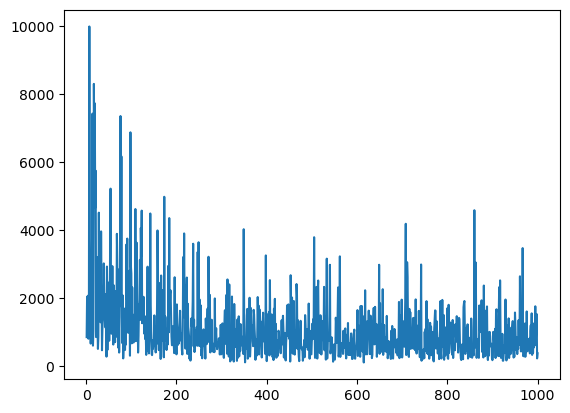

In [47]:
# Hyperparameters
n_training_episodes = 1000
gamma = 0.99
learning_rate = 0.00025  # 0.1
max_training_steps = 10000

# Exploration parameters
epsilon_max = 1
epsilon_min = 0.01

# replay memory parameters
replay_size = 100000
batch_size = 32


# fixed target network
fixed_target = True
copy_target = 30000


debug = True
double = True       # DDQN
dueling = True      # Dueling Network

car = TrainMountainCar(n_training_episodes=n_training_episodes, gamma=gamma, learning_rate=learning_rate,
                       epsilon_max=epsilon_max, epsilon_min=epsilon_min,
                       max_steps=max_training_steps, batch_size=batch_size, fixed_target=fixed_target,
                       copy_target=copy_target, replay_size=replay_size, double=double, dueling=dueling, debug=debug)

total_rewards, total_steps_list, q_measures, best_policy, evaluations = car.train()

torch.save(best_policy, 'data/Dueling_DDQN.pth')
np.savetxt(f'data/steps_Dueling_DDQN.txt', total_steps_list)
np.savetxt(f'data/q_values_Dueling_DDQN.txt', q_measures)
np.savetxt(f'data/eval_Dueling_DDQN.txt', evaluations)

plt.plot(np.arange(len(total_steps_list)) + 1, total_steps_list, zorder=0, label='training')
x = np.arange(50, n_training_episodes+1, 50)
plt.scatter(x, -evaluations, color='r', marker='x', zorder=1, label='evaluations')
N = 10
steps_mean = running_mean(total_steps_list, N)
plt.plot(np.arange(len(steps_mean)) + 1, steps_mean, zorder=0, label='running average')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps per Episode - Dueling_DDQN')
plt.savefig('plots/steps_Dueling_DDQN.png')
plt.close()

plt.plot(np.arange(len(q_measures)) + 1, q_measures)
plt.xlabel('Episode')
plt.ylabel('Average Q')
plt.title('Average Q measure over sampled states')
plt.savefig('plots/q_measures_Dueling_DDQN.png')
plt.close()

## DRQN

In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from helper_DQN import scale_and_resize
import collections
import random
import gymnasium as gym
import torchvision.transforms as transforms

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = torch.device("cuda")


class DRQN(nn.Module):
    def __init__(self, outputs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(10, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.lstm = nn.LSTM(3136, 512, bidirectional=False)
        self.out = nn.Linear(512, outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.flatten(x)
        x, _ = self.lstm(x)
        x = self.out(x)
        return x

class RecurrentExperienceMemory:
    def __init__(self, capacity, sequence_length=10):
        self.capacity = capacity
        self.memory = []
        self.seq_length = sequence_length

    def add(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        finish = random.sample(range(0, len(self.memory)), batch_size)
        begin = [x - self.seq_length for x in finish]
        samp = []
        for start, end in zip(begin, finish):
            # correct for sampling near beginning
            final = self.memory[max(start + 1, 0):end + 1]

            # correct for sampling across episodes
            for i in range(len(final) - 2, -1, -1):
                if final[i][3] is None:
                    final = final[i + 1:]
                    break

            # pad beginning to account for corrections
            while (len(final) < self.seq_length):
                final = [(np.zeros_like(self.memory[0][0].cpu()), 0, 0, np.zeros_like(self.memory[0][3].cpu()))] + final

            samp += final

        # returns flattened version
        return samp, None, None

    def __len__(self):
        return len(self.memory)


class TrainRecurrentMountainCar:
    def __init__(self, n_training_episodes=200, gamma=0.99, learning_rate=0.1, epsilon_max=0.5,
                 epsilon_min=0.05, decay_rate=0.005, max_steps=10000, batch_size=32, fixed_target=False,
                 copy_target=10000, replay_size=100000, double=False, dueling=False, prioritized=False, debug=False,
                 eval_epsilon=0.05, eval_episodes=25, eval_every=50, noisy=False, distributional=False, env=None):
        self.n_training_episodes = n_training_episodes
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.decay_rate = decay_rate
        self.max_steps = max_steps
        self.batch_size = batch_size
        self.fixed_target = fixed_target
        self.copy_target = copy_target
        self.replay_size = replay_size
        self.double = double
        self.dueling = dueling
        self.debug = debug
        self.eval_epsilon = eval_epsilon
        self.eval_episodes = eval_episodes
        self.eval_every = eval_every
        self.sequence_length = 10
        self.seq = [np.zeros(1) for _ in range(self.sequence_length)]

    # def epsilon_greedy_policy(self, policy: torch.nn.Module, X, epsilon: float, env: gym.envs):
    #     """
    #     Samples a random action with probability epsilon and picks the maximum action under policy network otherwise.
    #     :param policy: Policy Network under which to take action
    #     :param X: stacked tensor of shape (4,80,120)
    #     :param epsilon: float probability of sampling a random action
    #     :param env: Gymnasium environment
    #     :return: Randomly sampled action or maximum action under policy network
    #     """
    #     if random.uniform(0, 1) < epsilon:
    #         return env.action_space.sample()
    #     else:
    #         with torch.no_grad():
    #             X = X.unsqueeze(0).to(device)
    #             return policy(X).max(1)[1].view(1, 1).item()

    def get_action(self, policy, s, eps=0.1):
        with torch.no_grad():
            self.seq.pop(0)
            self.seq.append(s)
            if np.random.random() >= eps:
                X = torch.tensor(np.vstack(self.seq).astype(np.float32), device=device, dtype=torch.float)
                a = policy(X.unsqueeze(0))
                # a = a[:, -1, :]  # select last element of seq
                a = a.max(1)[1]
                return a.item()
            else:
                return env.action_space.sample()

    def initialize_measuring_states(self, env):
        """
        Randomly samples 200 states by taking random actions
        :param env: Gymnasium environment
        :return: list of states that were visited by random walk
        """
        measuring_states = []
        env.reset()
        for i in range(200):
            action = env.action_space.sample()
            env.step(action)
            img = env.render()
            img = transforms.ToTensor()(img)
            measuring_states.append(transform(img))
        env.reset()
        return measuring_states

    def eval(self, policy: torch.nn.Module, env: gym.envs):
        """
        Evaluate a policy and return the average reward over self.eval_episodes trials with maximum 10000 steps each
        :param policy: The policy to be evaluated
        :param env: The Gymnasium environment
        :return: average over rewards collected turing trials
        """
        rewards_list = []
        for episode in range(self.eval_episodes):
            env.reset()

            # up to 30 no-op actions
            noop = random.randint(0, 30)
            for i in range(noop):
                action = env.action_space.sample()
                env.step(action)

            rewards = 0

            for i in range(0, self.max_steps):      # max episode length 10000
                img = env.render()
                img = transforms.ToTensor()(img)
                X = transform(img).to(device)

                # action = self.epsilon_greedy_policy(policy, X, self.eval_epsilon, env)
                action = self.get_action(policy, X, self.eval_epsilon)
                _, reward, terminated, _, _ = env.step(action)
                rewards += reward

                if terminated:
                    break

            rewards_list.append(rewards)

        return np.mean(rewards_list)

    def train(self):
        """
        trains DQN using a fixed target network if self.fixed_target == True, otherwise with the policy network.
        :return: list of total rewards, list of steps in each episode, q values over sampled states
        """

        # keep track of total steps and rewards
        total_steps = 0
        total_rewards = []
        total_steps_list = []
        evaluations = []

        # initialize states in which Q value is measured every X episodes to track progress
        measuring_states = self.initialize_measuring_states(env)
        q_measures = []

        # Initialize Experience Memory
        experience_memory = RecurrentExperienceMemory(self.replay_size)

        # initialize policy (and target) network
        if self.dueling:
            policy = DRQN(env.action_space.n).to(device)
            if self.fixed_target:
                target = DRQN(env.action_space.n).to(device)
                target.load_state_dict(policy.state_dict())
                target.eval()
        else:
            policy = DRQN(env.action_space.n).to(device)
            if self.fixed_target:
                target = DRQN(env.action_space.n).to(device)
                target.load_state_dict(policy.state_dict())
                target.eval()

        # Best values found during evaluation
        best_reward = - float('inf')
        best_policy = policy.state_dict()

        optimizer = torch.optim.Adadelta(policy.parameters(), lr=0.1)

        for episode in range(self.n_training_episodes):
            steps = 0
            rewards = 0

            env.reset()

            # up to 30 no-op actions
            noop = random.randint(0, 30)
            for i in range(noop):
                action = env.action_space.sample()
                env.step(action)

            # get starting state as input tensor
            img = env.render()
            img = transforms.ToTensor()(img)
            X = transform(img)

            while True:
                # linear epsilon decay based on steps
                epsilon = max(self.epsilon_max - ((self.epsilon_max - self.epsilon_min)/500000) * total_steps, self.epsilon_min)

                # Choose the action At using epsilon greedy policy
                # action = self.epsilon_greedy_policy(policy, X, epsilon, env)
                action = self.get_action(policy, X, epsilon)
                # take action
                _, reward, terminated, _, _ = env.step(action)
                img = env.render()
                img = transforms.ToTensor()(img)
                X_new = transform(img) if not terminated else None

                experience_memory.add((X, action, reward, X_new))

                steps += 1
                total_steps += 1

                if len(experience_memory) > self.batch_size:
                    # experiences = experience_memory.sample(self.batch_size)
                    # states, actions, _rewards, next_states, terminations = (i for i in zip(*experiences))
                    # a = (torch.tensor(actions).long().unsqueeze(dim=1)).to(device)
                    # r = torch.tensor(_rewards).unsqueeze(dim=1).to(device)
                    # states = np.vstack(states).astype(np.float32)
                    # states = torch.from_numpy(states)
                    # next_states = np.vstack(next_states).astype(np.float32)
                    # next_states = torch.from_numpy(next_states)
                    # states = torch.reshape(states, (self.batch_size, 1, 84, 84)).to(device)  # 80,120
                    # next_states = torch.reshape(next_states, (self.batch_size, 1, 84, 84)).to(device)
                    # mask = [i for i, x in enumerate(terminations) if not x]  # get all non-final states
                    #
                    # reward = torch.tensor([reward]).to(device)
                    # action = torch.tensor([action]).unsqueeze(0).to(device)
                    # state = X.unsqueeze(0)
                    # new_state = X_new.unsqueeze(0)
                    #
                    # steps += 1
                    # total_steps += 1
                    #
                    # state_action_values = policy(states).gather(1, a)
                    #
                    # next_state_values = torch.zeros(self.batch_size, device=device)
                    #
                    # # update network
                    # if self.double:
                    #     max_next_action = policy(next_states).max(1)[1].view(-1, 1)
                    #     next_state_values[mask] = target(next_states[mask]).gather(1, max_next_action[mask]).squeeze(1)
                    # elif self.fixed_target:
                    #     next_state_values[mask] = target(next_states[mask]).max(1)[0].detach()
                    # else:
                    #     next_state_values[mask] = policy(next_states[mask]).max(1)[0].detach()
                    # # Compute the expected Q values
                    # expected_state_action_values = (next_state_values * self.gamma) + r.squeeze(1)

                    transitions, _, _ = experience_memory.sample(self.batch_size)

                    batch_state, batch_action, batch_reward, batch_next_state = zip(*transitions)

                    batch_state = np.vstack(batch_state).astype(np.float32)
                    # batch_state = torch.from_numpy(batch_state)
                    batch_next_state = np.vstack(batch_next_state).astype(np.float32)
                    # batch_next_state = torch.from_numpy(batch_next_state)

                    shape = (self.batch_size, self.sequence_length, 84, 84)
                    batch_state = torch.tensor(batch_state, device=device, dtype=torch.float).view(shape)
                    batch_action = torch.tensor(batch_action, device=device, dtype=torch.long).view(
                        self.batch_size, self.sequence_length)
                    batch_reward = torch.tensor(batch_reward, device=device, dtype=torch.float).view(
                        self.batch_size, self.sequence_length)
                    # get set of next states for end of each sequence
                    batch_next_state = tuple([batch_next_state[i] for i in range(len(batch_next_state)) if
                                              (i + 1) % (self.sequence_length) == 0])

                    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_next_state)),
                                                  device=device, dtype=torch.uint8)
                    try:  # sometimes all next states are false, especially with nstep returns
                        non_final_next_states = torch.tensor(np.array([s for s in batch_next_state if s is not None]),
                                                             device=device, dtype=torch.float).unsqueeze(dim=1)
                        non_final_next_states = torch.cat([batch_next_state[non_final_mask, 1:, :], non_final_next_states],
                                                          dim=1)
                        empty_next_state_values = False
                    except:
                        non_final_next_states = None
                        empty_next_state_values = True

                    # estimate
                    current_q_values = policy(batch_state.squeeze())
                    current_q_values = current_q_values.gather(1, batch_action).squeeze()

                    # target
                    with torch.no_grad():
                        max_next_q_values = torch.zeros((self.batch_size, self.sequence_length), device=device,
                                                            dtype=torch.float)
                        if not empty_next_state_values:
                            max_next, _ = target(non_final_next_states)
                            max_next_q_values[non_final_mask] = max_next.max(dim=2)[0]
                        expected_q_values = batch_reward + (self.gamma * max_next_q_values)

                    # loss = torch.nn.MSELoss()(state_action_values, expected_state_action_values.unsqueeze(1)).squeeze()
                    loss = torch.nn.MSELoss()(current_q_values, expected_q_values)

                    loss = loss.mean()

                    # Optimize the model
                    optimizer.zero_grad()
                    loss.backward()

                    torch.nn.utils.clip_grad_norm_(policy.parameters(), 10.)    # clip gradients
                    optimizer.step()

                # Update total reward
                rewards += reward

                # update current state to be next state
                X = X_new

                # If done, finish the episode
                if terminated or steps >= self.max_steps:  # or truncated:
                    # Track rewards
                    total_rewards.append(rewards)
                    total_steps_list.append(steps)

                    # measure Q values in selected states
                    Q_states = torch.stack(measuring_states).to(device)
                    Q_states = torch.unique(Q_states, dim=0, sorted=False)  # eliminate duplicate states
                    with torch.no_grad():
                        q_measures.append(torch.mean(policy(Q_states).max(1)[0]).item())

                    # Evaluate current policy and save optimal policy weights
                    if episode == self.n_training_episodes-1 or (episode > 0 and episode % self.eval_every == 0):
                        eval_reward = self.eval(policy, env)
                        if eval_reward > best_reward:
                            best_reward = eval_reward
                            best_policy = policy.state_dict()
                        print(f"Evaluation: {int(episode/self.eval_every)}\t average reward: {eval_reward}")
                        evaluations.append(eval_reward)

                    # print training information
                    if self.debug:
                        print(f"episode: {episode + 1:03d}\t steps: {steps + 1:05d}\t total steps:"
                              f"{total_steps + 1:06d}\t epsilon: {epsilon:.2f}\t average Q: {q_measures[-1]:.3f}")
                    break

                if self.fixed_target:
                    # copy policy network weights to target net every copy_target steps
                    if total_steps % self.copy_target <= 4:
                        target.load_state_dict(policy.state_dict())

        return total_rewards, total_steps_list, q_measures, best_policy, evaluations


# Hyperparameters
n_training_episodes = 1000
gamma = 0.99
learning_rate = 0.1  # 0.1
max_training_steps = 10000

# Exploration parameters
epsilon_max = 1
epsilon_min = 0.1

# replay memory parameters
replay_size = 100000
batch_size = 32

# fixed target network
fixed_target = True
copy_target = 10000

debug = True

transform = scale_and_resize()

env = gym.make('MountainCar-v0', render_mode='rgb_array')

car = TrainRecurrentMountainCar(n_training_episodes=n_training_episodes, gamma=gamma, learning_rate=learning_rate,
                       epsilon_max=epsilon_max, epsilon_min=epsilon_min,
                       max_steps=max_training_steps, batch_size=batch_size, fixed_target=fixed_target,
                       copy_target=copy_target, debug=debug, env=env)

total_rewards, total_steps_list, q_measures, best_policy, evaluations = car.train()

# save best policy as well as steps and q measures
torch.save(best_policy, 'data/DRQN_final.pth')
np.savetxt(f'data/steps_DRQN_txt', total_steps_list)
np.savetxt(f'data/q_values_DRQN.txt', q_measures)
np.savetxt(f'data/eval_DRQN.txt', evaluations)

# Plot steps per episode
plt.plot(np.arange(len(total_steps_list)) + 1, total_steps_list, zorder=0, label='training')
x = np.arange(50, n_training_episodes+1, 50)
plt.scatter(x, [-e for e in evaluations], color='r', marker='x', zorder=1, label='evaluations')
N = 10
steps_mean = running_mean(total_steps_list, N)
plt.plot(np.arange(len(steps_mean)) + 1, steps_mean, zorder=0, label='running average')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps per Episode - DRQN')
plt.savefig('plots/steps_DRQN.png')
plt.close()

# Plot q measures per episode
plt.plot(np.arange(len(q_measures)) + 1, q_measures)
plt.xlabel('Episode')
plt.ylabel('Average Q')
plt.title('Average Q measure over sampled states')
plt.savefig('plots/q_measures_DRQN.png')
plt.close()


KeyboardInterrupt: 

## DQN

episode: 001	 steps: 01501	 total steps:001501	 epsilon: 1.00	 average Q: 572.241
episode: 002	 steps: 01205	 total steps:002705	 epsilon: 1.00	 average Q: 27.023
episode: 003	 steps: 02213	 total steps:004917	 epsilon: 0.99	 average Q: -6.215
episode: 004	 steps: 00625	 total steps:005541	 epsilon: 0.99	 average Q: 834.716
episode: 005	 steps: 07773	 total steps:013313	 epsilon: 0.98	 average Q: 2587.646
episode: 006	 steps: 02713	 total steps:016025	 epsilon: 0.97	 average Q: 133.367
episode: 007	 steps: 01825	 total steps:017849	 epsilon: 0.97	 average Q: 7157.147
episode: 008	 steps: 01141	 total steps:018989	 epsilon: 0.97	 average Q: 146.755
episode: 009	 steps: 00657	 total steps:019645	 epsilon: 0.96	 average Q: 4432.949
episode: 010	 steps: 02961	 total steps:022605	 epsilon: 0.96	 average Q: -86.405
episode: 011	 steps: 01893	 total steps:024497	 epsilon: 0.96	 average Q: -42.757
episode: 012	 steps: 04105	 total steps:028601	 epsilon: 0.95	 average Q: -7.750
episode: 013	 st

Evaluation: 2	 average reward: -10000.0
episode: 101	 steps: 02381	 total steps:271985	 epsilon: 0.51	 average Q: -33.047
episode: 102	 steps: 05349	 total steps:277333	 epsilon: 0.50	 average Q: -29.119
episode: 103	 steps: 01245	 total steps:278577	 epsilon: 0.50	 average Q: -42.290
episode: 104	 steps: 04233	 total steps:282809	 epsilon: 0.49	 average Q: -9.710
episode: 105	 steps: 02645	 total steps:285453	 epsilon: 0.49	 average Q: -19.757
episode: 106	 steps: 06233	 total steps:291685	 epsilon: 0.47	 average Q: -19.124
episode: 107	 steps: 03973	 total steps:295657	 epsilon: 0.47	 average Q: -19.985
episode: 108	 steps: 10001	 total steps:305657	 epsilon: 0.45	 average Q: 522.634
episode: 109	 steps: 02205	 total steps:307861	 epsilon: 0.45	 average Q: -38.666
episode: 110	 steps: 01557	 total steps:309417	 epsilon: 0.44	 average Q: -38.941
episode: 111	 steps: 02005	 total steps:311421	 epsilon: 0.44	 average Q: 3928.886
episode: 112	 steps: 01241	 total steps:312661	 epsilon: 0

episode: 200	 steps: 00957	 total steps:555305	 epsilon: 0.10	 average Q: 43576.859
Evaluation: 4	 average reward: -10000.0
episode: 201	 steps: 00549	 total steps:555853	 epsilon: 0.10	 average Q: 4954.537
episode: 202	 steps: 04189	 total steps:560041	 epsilon: 0.10	 average Q: -51.539
episode: 203	 steps: 00833	 total steps:560873	 epsilon: 0.10	 average Q: 346.393
episode: 204	 steps: 02697	 total steps:563569	 epsilon: 0.10	 average Q: -21.748
episode: 205	 steps: 04905	 total steps:568473	 epsilon: 0.10	 average Q: 3513.716
episode: 206	 steps: 00917	 total steps:569389	 epsilon: 0.10	 average Q: 2088.306
episode: 207	 steps: 00829	 total steps:570217	 epsilon: 0.10	 average Q: -67.245
episode: 208	 steps: 01953	 total steps:572169	 epsilon: 0.10	 average Q: -43.173
episode: 209	 steps: 01465	 total steps:573633	 epsilon: 0.10	 average Q: -17.221
episode: 210	 steps: 01521	 total steps:575153	 epsilon: 0.10	 average Q: -46.367
episode: 211	 steps: 02497	 total steps:577649	 epsil

episode: 299	 steps: 03297	 total steps:824061	 epsilon: 0.10	 average Q: 62.158
episode: 300	 steps: 03073	 total steps:827133	 epsilon: 0.10	 average Q: -17.828
Evaluation: 6	 average reward: -4674.08
episode: 301	 steps: 08237	 total steps:835369	 epsilon: 0.10	 average Q: -42.270
episode: 302	 steps: 04357	 total steps:839725	 epsilon: 0.10	 average Q: -19.350
episode: 303	 steps: 00421	 total steps:840145	 epsilon: 0.10	 average Q: -39.637
episode: 304	 steps: 01953	 total steps:842097	 epsilon: 0.10	 average Q: 22.921
episode: 305	 steps: 02473	 total steps:844569	 epsilon: 0.10	 average Q: 589.105
episode: 306	 steps: 00709	 total steps:845277	 epsilon: 0.10	 average Q: -106.261
episode: 307	 steps: 03273	 total steps:848549	 epsilon: 0.10	 average Q: -14.203
episode: 308	 steps: 06109	 total steps:854657	 epsilon: 0.10	 average Q: 6313.911
episode: 309	 steps: 00653	 total steps:855309	 epsilon: 0.10	 average Q: 5492.191
episode: 310	 steps: 00829	 total steps:856137	 epsilon: 

episode: 398	 steps: 01241	 total steps:1074105	 epsilon: 0.10	 average Q: 15423.795
episode: 399	 steps: 01693	 total steps:1075797	 epsilon: 0.10	 average Q: 2703.891
episode: 400	 steps: 01393	 total steps:1077189	 epsilon: 0.10	 average Q: 7743.626
Evaluation: 8	 average reward: -10000.0
episode: 401	 steps: 01053	 total steps:1078241	 epsilon: 0.10	 average Q: 30696.670
episode: 402	 steps: 00901	 total steps:1079141	 epsilon: 0.10	 average Q: 7174.039
episode: 403	 steps: 02205	 total steps:1081345	 epsilon: 0.10	 average Q: 9.802
episode: 404	 steps: 01257	 total steps:1082601	 epsilon: 0.10	 average Q: -26.166
episode: 405	 steps: 01541	 total steps:1084141	 epsilon: 0.10	 average Q: -71.971
episode: 406	 steps: 03597	 total steps:1087737	 epsilon: 0.10	 average Q: -1.958
episode: 407	 steps: 02321	 total steps:1090057	 epsilon: 0.10	 average Q: -46.707
episode: 408	 steps: 03709	 total steps:1093765	 epsilon: 0.10	 average Q: -24.813
episode: 409	 steps: 01189	 total steps:109

episode: 496	 steps: 01257	 total steps:1331597	 epsilon: 0.10	 average Q: 9735.283
episode: 497	 steps: 02045	 total steps:1333641	 epsilon: 0.10	 average Q: 494.249
episode: 498	 steps: 03241	 total steps:1336881	 epsilon: 0.10	 average Q: 101.914
episode: 499	 steps: 01045	 total steps:1337925	 epsilon: 0.10	 average Q: 914.676
episode: 500	 steps: 00741	 total steps:1338665	 epsilon: 0.10	 average Q: 5297.345
Evaluation: 10	 average reward: -10000.0
episode: 501	 steps: 06125	 total steps:1344789	 epsilon: 0.10	 average Q: 3509.895
episode: 502	 steps: 01373	 total steps:1346161	 epsilon: 0.10	 average Q: -59.768
episode: 503	 steps: 03301	 total steps:1349461	 epsilon: 0.10	 average Q: -23.946
episode: 504	 steps: 01837	 total steps:1351297	 epsilon: 0.10	 average Q: 12286.205
episode: 505	 steps: 01893	 total steps:1353189	 epsilon: 0.10	 average Q: 9481.734
episode: 506	 steps: 01261	 total steps:1354449	 epsilon: 0.10	 average Q: -131.102
episode: 507	 steps: 01117	 total steps

episode: 594	 steps: 04993	 total steps:1582665	 epsilon: 0.10	 average Q: -58.933
episode: 595	 steps: 01981	 total steps:1584645	 epsilon: 0.10	 average Q: 1784.258
episode: 596	 steps: 01873	 total steps:1586517	 epsilon: 0.10	 average Q: -56.547
episode: 597	 steps: 02369	 total steps:1588885	 epsilon: 0.10	 average Q: 10679.375
episode: 598	 steps: 03077	 total steps:1591961	 epsilon: 0.10	 average Q: -46.781
episode: 599	 steps: 00845	 total steps:1592805	 epsilon: 0.10	 average Q: -54.587
episode: 600	 steps: 02397	 total steps:1595201	 epsilon: 0.10	 average Q: -51.770
Evaluation: 12	 average reward: -4192.96
episode: 601	 steps: 00637	 total steps:1595837	 epsilon: 0.10	 average Q: -27.315
episode: 602	 steps: 03433	 total steps:1599269	 epsilon: 0.10	 average Q: 2651.102
episode: 603	 steps: 00753	 total steps:1600021	 epsilon: 0.10	 average Q: 59.290
episode: 604	 steps: 00577	 total steps:1600597	 epsilon: 0.10	 average Q: -1.087
episode: 605	 steps: 02525	 total steps:1603

episode: 692	 steps: 01277	 total steps:1820317	 epsilon: 0.10	 average Q: 516.468
episode: 693	 steps: 00633	 total steps:1820949	 epsilon: 0.10	 average Q: -4.234
episode: 694	 steps: 01153	 total steps:1822101	 epsilon: 0.10	 average Q: -47.260
episode: 695	 steps: 00409	 total steps:1822509	 epsilon: 0.10	 average Q: -60.125
episode: 696	 steps: 01753	 total steps:1824261	 epsilon: 0.10	 average Q: -33.065
episode: 697	 steps: 05117	 total steps:1829377	 epsilon: 0.10	 average Q: -34.596
episode: 698	 steps: 00789	 total steps:1830165	 epsilon: 0.10	 average Q: 325.900
episode: 699	 steps: 02257	 total steps:1832421	 epsilon: 0.10	 average Q: -14.496
episode: 700	 steps: 01281	 total steps:1833701	 epsilon: 0.10	 average Q: -49.524
Evaluation: 14	 average reward: -5055.2
episode: 701	 steps: 00497	 total steps:1834197	 epsilon: 0.10	 average Q: 6614.833
episode: 702	 steps: 00893	 total steps:1835089	 epsilon: 0.10	 average Q: 872.946
episode: 703	 steps: 04845	 total steps:1839933

episode: 790	 steps: 02965	 total steps:2089261	 epsilon: 0.10	 average Q: 806.027
episode: 791	 steps: 01617	 total steps:2090877	 epsilon: 0.10	 average Q: 0.078
episode: 792	 steps: 02385	 total steps:2093261	 epsilon: 0.10	 average Q: 354.118
episode: 793	 steps: 04097	 total steps:2097357	 epsilon: 0.10	 average Q: -13.871
episode: 794	 steps: 09261	 total steps:2106617	 epsilon: 0.10	 average Q: -9.066
episode: 795	 steps: 03725	 total steps:2110341	 epsilon: 0.10	 average Q: -43.213
episode: 796	 steps: 00865	 total steps:2111205	 epsilon: 0.10	 average Q: -26.475
episode: 797	 steps: 02921	 total steps:2114125	 epsilon: 0.10	 average Q: -6.037
episode: 798	 steps: 03337	 total steps:2117461	 epsilon: 0.10	 average Q: 30.574
episode: 799	 steps: 00833	 total steps:2118293	 epsilon: 0.10	 average Q: 668.600
episode: 800	 steps: 03765	 total steps:2122057	 epsilon: 0.10	 average Q: -64.221
Evaluation: 16	 average reward: -4996.8
episode: 801	 steps: 02629	 total steps:2124685	 eps

episode: 888	 steps: 06481	 total steps:2368769	 epsilon: 0.10	 average Q: -28.517
episode: 889	 steps: 03865	 total steps:2372633	 epsilon: 0.10	 average Q: 43.115
episode: 890	 steps: 00653	 total steps:2373285	 epsilon: 0.10	 average Q: 14.751
episode: 891	 steps: 01441	 total steps:2374725	 epsilon: 0.10	 average Q: 302.301
episode: 892	 steps: 03277	 total steps:2378001	 epsilon: 0.10	 average Q: -53.448
episode: 893	 steps: 04865	 total steps:2382865	 epsilon: 0.10	 average Q: -9.798
episode: 894	 steps: 05069	 total steps:2387933	 epsilon: 0.10	 average Q: 1838.500
episode: 895	 steps: 02817	 total steps:2390749	 epsilon: 0.10	 average Q: -1.999
episode: 896	 steps: 02205	 total steps:2392953	 epsilon: 0.10	 average Q: -36.226
episode: 897	 steps: 01801	 total steps:2394753	 epsilon: 0.10	 average Q: -22.726
episode: 898	 steps: 01921	 total steps:2396673	 epsilon: 0.10	 average Q: -38.721
episode: 899	 steps: 02865	 total steps:2399537	 epsilon: 0.10	 average Q: 29759.357
episo

episode: 986	 steps: 01253	 total steps:2650133	 epsilon: 0.10	 average Q: -43.949
episode: 987	 steps: 02161	 total steps:2652293	 epsilon: 0.10	 average Q: -44.369
episode: 988	 steps: 04785	 total steps:2657077	 epsilon: 0.10	 average Q: -64.771
episode: 989	 steps: 02881	 total steps:2659957	 epsilon: 0.10	 average Q: 2025.747
episode: 990	 steps: 00449	 total steps:2660405	 epsilon: 0.10	 average Q: 2.060
episode: 991	 steps: 04297	 total steps:2664701	 epsilon: 0.10	 average Q: -36.627
episode: 992	 steps: 01041	 total steps:2665741	 epsilon: 0.10	 average Q: -13.312
episode: 993	 steps: 01789	 total steps:2667529	 epsilon: 0.10	 average Q: -50.766
episode: 994	 steps: 01569	 total steps:2669097	 epsilon: 0.10	 average Q: -53.165
episode: 995	 steps: 02677	 total steps:2671773	 epsilon: 0.10	 average Q: 16633.025
episode: 996	 steps: 04333	 total steps:2676105	 epsilon: 0.10	 average Q: -6.645
episode: 997	 steps: 03913	 total steps:2680017	 epsilon: 0.10	 average Q: 2986.024
epi

TypeError: bad operand type for unary -: 'list'

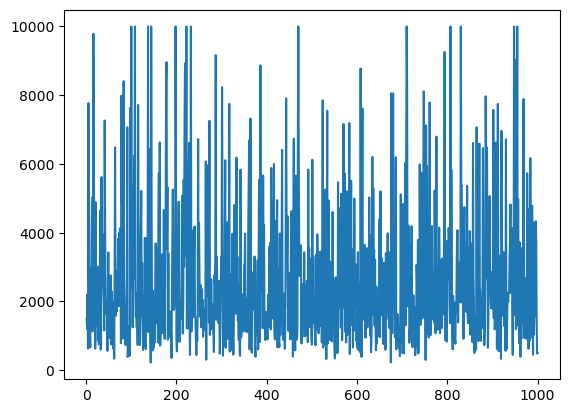

In [57]:
import torch
import numpy as np
# from TrainMountainCar import TrainMountainCar
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = torch.device("cuda")

# Hyperparameters
n_training_episodes = 1000
gamma = 0.99
learning_rate = 0.00025
max_training_steps = 10000

# Exploration parameters
epsilon_max = 1
epsilon_min = 0.1

# replay memory parameters
replay_size = 100000
batch_size = 32

Experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

car = TrainMountainCar(n_training_episodes=n_training_episodes, gamma=gamma, learning_rate=learning_rate,
                       epsilon_max=epsilon_max, epsilon_min=epsilon_min, replay_size=replay_size,
                       max_steps=max_training_steps, batch_size=batch_size, debug=True)

total_rewards, total_steps_list, q_measures, best_policy, evaluations = car.train()

# save best policy as well as steps and q measures
torch.save(best_policy, 'data/DQN.pth')
np.savetxt(f'data/steps_DQN.txt', total_steps_list)
np.savetxt(f'data/q_values_DQN.txt', q_measures)
np.savetxt(f'data/eval_DQN.txt', evaluations)


# Plot steps per episode
plt.plot(np.arange(len(total_steps_list)) + 1, total_steps_list, zorder=0, label='training')
plt.scatter([50, 100, 150, 200, 250, 300, 350, 400, 450, 500], -evaluations, color='r', marker='x', zorder=1, label='evaluations')
N = 10
steps_mean = running_mean(total_steps_list, N)
plt.plot(np.arange(len(steps_mean)) + 1, steps_mean, zorder=0, label='running average')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps per Episode - DQN')
plt.savefig('plots/steps_DQN.png')
plt.close()

# Plot q measures per episode
plt.plot(np.arange(len(q_measures)) + 1, q_measures)
plt.xlabel('Episode')
plt.ylabel('Average Q')
plt.title('Average Q measure over sampled states')
plt.savefig('plots/q_measures_DQN.png')
plt.close()


## Distributional DDQN

In [60]:
# Hyperparameters
n_training_episodes = 1000
gamma = 0.99
learning_rate = 0.00025  # 0.1
max_training_steps = 10000

# Exploration parameters
epsilon_max = 1
epsilon_min = 0.01

# replay memory parameters
replay_size = 100000
batch_size = 32


# fixed target network
fixed_target = True
copy_target = 10000


debug = True
distributional = True

Experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

car = TrainMountainCar(n_training_episodes=n_training_episodes, gamma=gamma, learning_rate=learning_rate,
                       epsilon_max=epsilon_max, epsilon_min=epsilon_min, distributional=distributional,
                       max_steps=max_training_steps, batch_size=batch_size, fixed_target=fixed_target,
                       copy_target=copy_target, replay_size=replay_size, debug=debug)

total_rewards, total_steps_list, q_measures, best_policy, evaluations = car.train()

# Save best policy, as well as steps and q measures
torch.save(best_policy, 'data/Distributional_DDQN.pth')
np.savetxt(f'data/steps_Distributional_DDQN.txt', total_steps_list)
np.savetxt(f'data/q_values_Distributional_DDQN.txt', q_measures)
np.savetxt(f'data/eval_Distributional_DDQN.txt', evaluations)

# Plot steps over episodes
plt.plot(np.arange(len(total_steps_list)) + 1, total_steps_list, zorder=0, label='training')
x = np.arange(50, n_training_episodes+1, 50)
plt.scatter(x, [-e for e in evaluations], color='r', marker='x', zorder=1, label='evaluations')
N = 10
steps_mean = running_mean(total_steps_list, N)
plt.plot(np.arange(len(steps_mean)) + 1, steps_mean, zorder=0, label='running average')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps per Episode - Distributional_DDQN')
plt.savefig('plots/steps_Distributional_DDQN.png')
plt.close()

# Plot Q measures over episodes
plt.plot(np.arange(len(q_measures)) + 1, q_measures)
plt.xlabel('Episode')
plt.ylabel('Average Q')
plt.title('Average Q measure over sampled states')
plt.savefig('plots/q_measures_Distributional_DDQN.png')
plt.close()

TypeError: data type 'experience' not understood

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = torch.device("cuda")

# Hyperparameters
n_training_episodes = 1000
gamma = 0.99
learning_rate = 0.00025  # 0.1
max_training_steps = 10000

# Exploration parameters
epsilon_max = 1
epsilon_min = 0.01

# replay memory parameters
replay_size = 100000
batch_size = 32


# fixed target network
fixed_target = True
copy_target = 30000


debug = True
double = True
noisy = True

car = TrainMountainCar(n_training_episodes=n_training_episodes, gamma=gamma, learning_rate=learning_rate,
                       epsilon_max=epsilon_max, epsilon_min=epsilon_min,
                       max_steps=max_training_steps, batch_size=batch_size, fixed_target=fixed_target,
                       copy_target=copy_target, replay_size=replay_size, double=double, debug=debug, noisy=noisy)

total_rewards, total_steps_list, q_measures, best_policy, evaluations = car.train()

# Save best policy, as well as steps and q measures
torch.save(best_policy, 'data/Noisy_DDQN.pth')
np.savetxt(f'data/steps_Noisy_DDQN.txt', total_steps_list)
np.savetxt(f'data/q_values_Noisy_DDQN.txt', q_measures)
np.savetxt(f'data/eval_Noisy_DDQN.txt', evaluations)

# Plot steps over episodes
plt.plot(np.arange(len(total_steps_list)) + 1, total_steps_list, zorder=0, label='training')
plt.scatter([50, 100, 150, 200, 250, 300, 350, 400, 450, 500], -evaluations, color='r', marker='x', zorder=1, label='evaluations')
N = 10
steps_mean = running_mean(total_steps_list, N)
plt.plot(np.arange(len(steps_mean)) + 1, steps_mean, zorder=0, label='running average')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps per Episode - Noisy_DDQN')
plt.savefig('plots/steps_Noisy_DDQN.png')
plt.close()

# Plot Q measures over episodes
plt.plot(np.arange(len(q_measures)) + 1, q_measures)
plt.xlabel('Episode')
plt.ylabel('Average Q')
plt.title('Average Q measure over sampled states')
plt.savefig('plots/q_measures_Noisy_DDQN.png')
plt.close()


DependencyNotInstalled: pygame is not installed, run `pip install gymnasium[classic-control]`